# NOTEBOOK 1: PREDICTING TIME TO SELL EDA AND DATA PREPERATION

## Necessary Libraries

In this notebook, the following libraries are utilized:

In [2]:
#Importing libraries

#Libraries to clean and analyze the data
import pandas as pd
import seaborn as sns
from datetime import datetime
from datetime import date
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as stats

#Libraries for Topic Etraction
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from spacy.lang.nl.stop_words import STOP_WORDS
from spacy.lang.nl import Dutch
from spacy.lang.nl.examples import sentences
#!python -m spacy download nl_core_news_md

## Setting up the Dataset

### . . . . . Importing and First Look into Data

In [4]:
#Importing Funda Dataset
#csv = pd.read_csv('~/Desktop/DDB/ai_business/datasets/funda_dataset.csv', sep = ';')

#Importing CSV with encoding (sometimes necessary)
csv = pd.read_csv('~/Desktop/DDB/ai_business/datasets/funda_dataset.csv', sep = ';', encoding = 'latin1')
csv.head(3)

#Importing table that contains city names from the Netherlands - has been commented as the free table only has the most common cities (900 cities) but our dataset has more cities than that
#city_verifier = pd.read_csv('~/Desktop/DDB/ai_business/datasets/city_verifier.csv', sep = ',')

/Users/vanyamantek/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (2,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,url,title,price,postalcode,city,livingspace,plotarea,constructionyear,garden,energylabel,...,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72
0,https://www.funda.nl/koop/verkocht/breda/appar...,Cosunpark 1 C6,470000,4814 ND,Breda,105.0,2.0,2021,Elektra,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://www.funda.nl/koop/verkocht/utrecht/hui...,Bellamystraat 22,1195000,3514 EM,Utrecht,231.0,129.0,1904,Achtertuin,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.funda.nl/koop/verkocht/koedijk-gem...,De Bregjesakker 25,665000,1831 EP,Koedijk,126.0,473.0,2000,Tuin rondom,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#Check for which columns have been imported
csv.columns

Index(['url', 'title', 'price', 'postalcode', 'city', 'livingspace',
       'plotarea', 'constructionyear', 'garden', 'energylabel', 'housetype',
       'rooms', 'bathroom', 'description', 'offerdate', 'selldate', 'duration',
       'broker', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21',
       'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25',
       'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29',
       'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33',
       'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37',
       'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41',
       'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44', 'Unnamed: 45',
       'Unnamed: 46', 'Unnamed: 47', 'Unnamed: 48', 'Unnamed: 49',
       'Unnamed: 50', 'Unnamed: 51', 'Unnamed: 52', 'Unnamed: 53',
       'Unnamed: 54', 'Unnamed: 55', 'Unnamed: 56', 'Unnamed: 57',
       'Unnamed: 58', 'Unnamed: 59', 'Unnamed: 60', 'Unnamed: 61',
       'Unnamed: 62', 'Unna

In [6]:
#Removing empty columns (Unnamed: 19 - Unnamed 72)
funda = csv.iloc[:, 1:18]
#Checking if correct columns are there
funda.columns

Index(['title', 'price', 'postalcode', 'city', 'livingspace', 'plotarea',
       'constructionyear', 'garden', 'energylabel', 'housetype', 'rooms',
       'bathroom', 'description', 'offerdate', 'selldate', 'duration',
       'broker'],
      dtype='object')

In [7]:
#Checking the top of the data
funda.head()

,title,price,postalcode,city,livingspace,plotarea,constructionyear,garden,energylabel,housetype,rooms,bathroom,description,offerdate,selldate,duration,broker
0,Cosunpark 1 C6,470000,4814 ND,Breda,105.0,2.0,2021,Elektra,A,Portiekflat,3,1.0,Licht en luchtig wonen. In het driekamerappart...,10 mei 2021,19 oktober 2021,5 maanden,Van de Water Makelaars
1,Bellamystraat 22,1195000,3514 EM,Utrecht,231.0,129.0,1904,Achtertuin,C,Herenhuis,1,2.0,Exclusief Punt! Een prachtig herenhuis (ruim 2...,NaN,NaN,NaN,NaN
2,De Bregjesakker 25,665000,1831 EP,Koedijk,126.0,473.0,2000,Tuin rondom,B,Eengezinswoning,5,1.0,WONING WORDT VERKOCHT OP INSCHRIJVING. SLUITIN...,NaN,NaN,NaN,NaN
3,De Bongerd 2,325000,5345 JT,Oss,105.0,204.0,1985,Achtertuin en voortuin,B,Eengezinswoning,5,1.0,"Wat een leuke, goed onderhouden twee-onder-een...",23/Nov/21,09/Dec/21,2 weken,Akker Makelaardij
4,Simonstraat 85,175000,7553 NN,Hengelo,78.0,132.0,1986,Achtertuin en voortuin,C,Eengezinswoning,4,1.0,Starters opgelet: Wij hebben een leuke woning ...,23/Nov/21,08/Dec/21,2 weken,Prisma Era Makelaars Hengelo


In [8]:
#Describe dataset
funda.describe()

,livingspace,plotarea,rooms,bathroom
count,173043.000000,173043.000000,173043.000000,172969.000000
mean,120.850499,170.690092,4.574614,1.200735
std,52.197982,187.977163,1.475041,0.527072
min,1.026000,1.000000,1.000000,1.000000
25%,89.000000,3.000000,4.000000,1.000000
50%,113.000000,140.000000,5.000000,1.000000
75%,139.000000,242.000000,5.000000,1.000000
max,938.000000,999.000000,9.000000,9.000000


In [9]:
#Checking info for datatypes of variables
funda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173043 entries, 0 to 173042
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   title             173043 non-null  object 
 1   price             171267 non-null  object 
 2   postalcode        173041 non-null  object 
 3   city              173043 non-null  object 
 4   livingspace       173043 non-null  float64
 5   plotarea          173043 non-null  float64
 6   constructionyear  173043 non-null  object 
 7   garden            151768 non-null  object 
 8   energylabel       173043 non-null  object 
 9   housetype         173043 non-null  object 
 10  rooms             173043 non-null  int64  
 11  bathroom          172969 non-null  float64
 12  description       173043 non-null  object 
 13  offerdate         94612 non-null   object 
 14  selldate          94612 non-null   object 
 15  duration          94612 non-null   object 
 16  broker            94

In [10]:
#Checking Null entries
funda.isnull().sum

<bound method NDFrame._add_numeric_operations.<locals>.sum of         title  price  postalcode   city  livingspace  plotarea  \
0       False  False       False  False        False     False   
1       False  False       False  False        False     False   
2       False  False       False  False        False     False   
3       False  False       False  False        False     False   
4       False  False       False  False        False     False   
...       ...    ...         ...    ...          ...       ...   
173038  False  False       False  False        False     False   
173039  False  False       False  False        False     False   
173040  False  False       False  False        False     False   
173041  False  False       False  False        False     False   
173042  False  False       False  False        False     False   

        constructionyear  garden  energylabel  housetype  rooms  bathroom  \
0                  False   False        False      False  False     

### . . . . . Converting Datatypes

In order to analyze the data efficiently, it is necessary to convert all variables into the correct datatype. 

In [11]:
#PRICE
#Replace NaNs with 0s in the Price column so that we can convert it into an integer later
funda['price'].fillna(0, inplace = True)
#Since the price column could still not be immediately converted to an integer, we checked for why this is happening and found out that a few rows had "Verkoop bij inschrijving" instead of a price
#Check how many entries have this text instead of a price
#print(len(funda[funda['price'] == 'Verkoop bij inschrijving']))
#Replace non-numerical values from the price column with 0 (for NA)
funda['price'].replace('Verkoop bij inschrijving', 0, inplace = True)
#Finally turning it into an integer
funda['price'] = funda['price'].astype(int)

#HOUSETYPE
funda['housetype'] = funda['housetype'].astype('string')
funda[funda['housetype'].str.find("Beneden") != -1]['housetype'].unique()
funda['housetype'] = funda['housetype'].str.replace('Beneden \\+ bovenwoning', 'Beneden_en_Bovenwoning')
funda['housetype'] = funda['housetype'].str.split(' ').str[0]

#CITY
#Turning city into a string
funda['city'] = funda['city'].astype('string')

#GARDEN
funda['garden'] = funda['garden'].astype('string')
#LIVINGSPACE
funda['livingspace'] = funda['livingspace'].astype(int)
#PLOTAREA
funda['plotarea'] = funda['plotarea'].astype(int)
#DESCRIPTION
funda['description'] = funda['description'].astype('string')
#BROKER
funda['broker'] = funda['broker'].astype('string')

#ENERGYLABEL
#Removing all Energylabels above A, leaving only A
funda['energylabel'] = funda['energylabel'].astype('str')
funda['energylabel'] = funda['energylabel'].str.split('+').str[0]

#CONSTRUCTIONYEAR
#Turning constructionyear into an integer by cleaning up the column
funda['constructionyear'] = funda['constructionyear'].str.replace('Bevoor', '')
funda['constructionyear'] = funda['constructionyear'].str.replace('Na', '')
funda['constructionyear'] = funda['constructionyear'].str.replace('Voor', '')
#Only keep the first year mentioned when a range is given (eg. 1991-2000 will only keep 1991)
funda['constructionyear'] = funda['constructionyear'].str.split('-').str[0]
#Turning into an integer
funda['constructionyear'] = funda['constructionyear'].astype(int)

#OFFERDATE
#Translating (and replacing) Dutch months with English ones
funda['offerdate'] = funda['offerdate'].str.replace('januari', 'January')
funda['offerdate'] = funda['offerdate'].str.replace('februari', 'February')
funda['offerdate'] = funda['offerdate'].str.replace('maart', 'March')
funda['offerdate'] = funda['offerdate'].str.replace('mei', 'May')
funda['offerdate'] = funda['offerdate'].str.replace('juni', 'June')
funda['offerdate'] = funda['offerdate'].str.replace('juli', 'July')
funda['offerdate'] = funda['offerdate'].str.replace('augustus', 'August')
funda['offerdate'] = funda['offerdate'].str.replace('oktober', 'October')
#Turning into date
funda['offerdate'] = funda['offerdate'].astype('datetime64[ns]')

#SELLDATE
funda['selldate'] = funda['selldate'].str.replace('januari', 'January')
funda['selldate'] = funda['selldate'].str.replace('februari', 'February')
funda['selldate'] = funda['selldate'].str.replace('maart', 'March')
funda['selldate'] = funda['selldate'].str.replace('mei', 'May')
funda['selldate'] = funda['selldate'].str.replace('juni', 'June')
funda['selldate'] = funda['selldate'].str.replace('juli', 'July')
funda['selldate'] = funda['selldate'].str.replace('augustus', 'August')
funda['selldate'] = funda['selldate'].str.replace('oktober', 'October')
#Turning into date
funda['selldate'] = funda['selldate'].astype('datetime64[ns]')

#DURATION
#Turning ½ into 0.5, making it processable for python
funda['duration'] = funda['duration'].str.replace('½', '.5')
#Transform the duration column into days only in order to analzye it better
funda['duration'] = funda['duration'].str.replace('dagen', 'days')
funda['duration'] = funda['duration'].str.replace('1 dag', '1 day')
funda['duration'] = funda['duration'].str.replace('maanden', 'months')
funda['duration'] = funda['duration'].str.replace('weken', 'weeks')
#Split Duration column into two columns for converting
#funda[['old_format', 'time']] = funda.duration.str.split(' ', expand = True)
#funda['old_format'] = funda['old_format'].str.replace(' ', '')
#funda['old_format'].fillna(0, inplace = True)
#funda['duration'].fillna('NA', inplace = True)
#funda['month_days'] = np.nan
#funda['week_days'] = np.nan
#funda['total_days_on_funda'] = np.nan
#funda['old_format'] = funda['old_format'].astype(float)
#Convert all time intervals into days, first for months, then weeks
#funda['month_days'] = np.where(funda['time'] == 'months', funda['old_format'] * 30, funda['old_format'])
#funda['week_days'] = np.where(funda['time'] == 'weeks', funda['old_format'] * 7, funda['old_format'])

<ipython-input-11-bf52c17650dc>:15: FutureWarning: The default value of regex will change from True to False in a future version.
  funda['housetype'] = funda['housetype'].str.replace('Beneden \\+ bovenwoning', 'Beneden_en_Bovenwoning')


### . . . . . Adding extra columns for better analysis

For some variables, it makes sense to add extra columns. For instance, we are adding a "days till sold" column. Since the "duration" column is linked to how long the houses have been on Funda in total (including AFTER they have been sold), it is needed to calculate the total time to sell by using the selldate and offerdate as an indication.
We are also adding another column about the garden, "garden_bool". We noticed that sometimes the "garden" column also had houses with a balcony or a terasse mentioned which does not count as a garden. It also occassionally had completely wrong words. 
Therefore, the "garden_bool" column simply returns True or False if a garden ("tuin" or "Tuin") is mentioned. 

In [12]:
#TOTAL DAYS ON FUNDA
#Adding them into one final column
#funda['total_days_on_funda'] = funda[['month_days', 'week_days']].max(axis = 1)
#Turning days on funda into an integer
#funda['total_days_on_funda'] = funda['total_days_on_funda'].astype(int)

#DAYS TILL SOLD
funda['days_till_sold'] = funda['selldate'] - funda['offerdate']
funda['days_till_sold'] = funda['days_till_sold'].astype('str')
funda['days_till_sold'] = funda['days_till_sold'].str.replace('days', '')
funda['days_till_sold'] = funda['days_till_sold'].str.replace('NaT', '0')
funda['days_till_sold'] = funda['days_till_sold'].astype(int)

#GARDEN BOOLEAN
funda['garden_bool'] = funda['garden'].str.contains('Tuin|tuin')

        offerdate   selldate  days_till_sold
0      2021-05-10 2021-10-19             162
1             NaT        NaT               0
2             NaT        NaT               0
3      2021-11-23 2021-12-09              16
4      2021-11-23 2021-12-08              15
...           ...        ...             ...
173038        NaT        NaT               0
173039 2021-10-20 2021-11-04              15
173040        NaT        NaT               0
173041        NaT        NaT               0
173042        NaT        NaT               0

[173043 rows x 3 columns]


### . . . . . Storing new dataset

The dataset is almost clean. It is stored in a seperate object, and the columns are rearranged for better readability. 

In [13]:
#Storing the now clean dataset in a new object
#Dropping columns we created before (not useful anymore)
#funda_clean = funda.drop(['old_format', 'time', 'month_days', 'week_days'], axis = 1)
#Rearranging the columns 
funda_clean = funda[['title', 'price', 'postalcode', 'city', 'livingspace', 'plotarea', 'constructionyear', 'garden', 'garden_bool', 'energylabel', 'housetype', 'rooms', 'bathroom', 'offerdate', 'selldate', 'days_till_sold', 'duration', 'description', 'broker']]
funda_clean.head()

,title,price,postalcode,city,livingspace,plotarea,constructionyear,garden,garden_bool,energylabel,housetype,rooms,bathroom,offerdate,selldate,days_till_sold,duration,description,broker
0,Cosunpark 1 C6,470000,4814 ND,Breda,105,2,2021,Elektra,False,A,Portiekflat,3,1.0,2021-05-10,2021-10-19,162,5 months,Licht en luchtig wonen. In het driekamerappart...,Van de Water Makelaars
1,Bellamystraat 22,1195000,3514 EM,Utrecht,231,129,1904,Achtertuin,True,C,Herenhuis,1,2.0,NaT,NaT,0,NaN,Exclusief Punt! Een prachtig herenhuis (ruim 2...,<NA>
2,De Bregjesakker 25,665000,1831 EP,Koedijk,126,473,2000,Tuin rondom,True,B,Eengezinswoning,5,1.0,NaT,NaT,0,NaN,WONING WORDT VERKOCHT OP INSCHRIJVING. SLUITIN...,<NA>
3,De Bongerd 2,325000,5345 JT,Oss,105,204,1985,Achtertuin en voortuin,True,B,Eengezinswoning,5,1.0,2021-11-23,2021-12-09,16,2 weeks,"Wat een leuke, goed onderhouden twee-onder-een...",Akker Makelaardij
4,Simonstraat 85,175000,7553 NN,Hengelo,78,132,1986,Achtertuin en voortuin,True,C,Eengezinswoning,4,1.0,2021-11-23,2021-12-08,15,2 weeks,Starters opgelet: Wij hebben een leuke woning ...,Prisma Era Makelaars Hengelo


### . . . . . Dealing with Outliers, Weird Data and Missing Values

Even though datatypes have been converted and new columns have been added, we still need to deal with odd entries such as outliers or missing values.

(0.0, 10000.0)

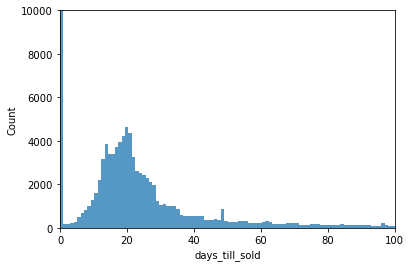

In [14]:
#Visualizing the Outliers
hist = sns.histplot(data = funda_clean, x = 'days_till_sold', bins = 5000)
hist.set_xlim(0, 100)
hist.set_ylim(0, 10000)

Here we see that there are a ton of houses sold in 0 days. These are likely wrong entries, or perhaps these houses were already sold when they first appeared on Funda. 
When visualizing this dataset, these outliers will make our data messy and hard to interpret. That is why it would be best to remove them and focus on the bell-shaped distribution between 1-50 days.

(0.0, 10000.0)

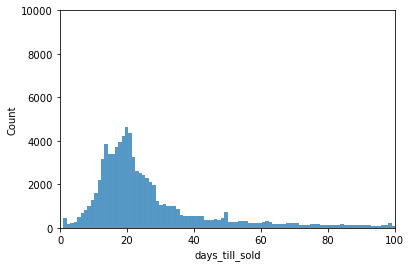

In [15]:
#Storing data without days till sold = 0 in another dataset
funda_no0days = funda_clean[funda_clean['days_till_sold'] > 0]

#Visualizing the new dataset
hist_filtered = sns.histplot(data = funda_no0days, x = 'days_till_sold', bins = 5000)
hist_filtered.set_xlim(0, 100)
hist_filtered.set_ylim(0, 10000)

Now, the distribution looks a lot more realistic. We still want to remove the heavy outliers from this new dataset though. For this, we use the Z-Score to understand how far the data points are from the mean.
_Z-Score = (data_point - mean) / std.deviation_

In [16]:
#Setting Threshold Level
threshold = 3 
#Column that contains z-score based on days till sold 
funda_no0days['z_days'] = np.abs(stats.zscore(funda_no0days['days_till_sold']))
#Making boolean column to indicate if something is an outlier or not
funda_no0days['outliers'] = abs(funda_no0days['z_days'] > threshold).astype(int)
#Storing a dataset that excludes the outliers
funda_no_outliers = funda_no0days[funda_no0days['outliers'] == 0]

<ipython-input-16-6ce7a6ecb309>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funda_no0days['z_days'] = np.abs(stats.zscore(funda_no0days['days_till_sold']))
<ipython-input-16-6ce7a6ecb309>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funda_no0days['outliers'] = abs(funda_no0days['z_days'] > threshold).astype(int)


In [17]:
#Only including rows in which Livingspace < Plotarea
funda_no_outliers = funda_no_outliers[funda_no_outliers['livingspace'] < funda_no_outliers['plotarea']]

<AxesSubplot:>

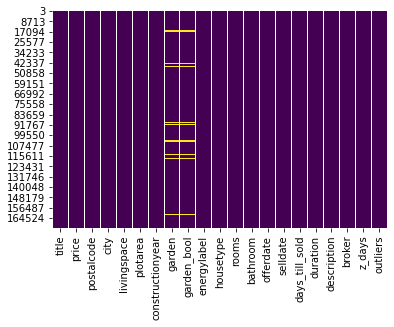

In [18]:
#Visualizing the still missing values
sns.heatmap(funda_no_outliers.isnull(), cbar = False, cmap = 'viridis')

Lastly, we drop the remaining rows that have missing values.

In [19]:
#Dropping missing values
print("With missing values, our dataset has", len(funda_no_outliers), "rows.")
print("By dropping missing values, our dataset will be left with", len(funda_no_outliers.dropna()), "rows.")
#Storing final dataset in funda_final
funda_no_outliers_no_na = funda_no_outliers.dropna()

With missing values, our dataset has 56097 rows.
By dropping missing values, our dataset will be left with 52967 rows.


After removing all those outliers, we are still want to remove cities that appear only once. We also notice a wrong entry of a city called "Den", probably Den Hague or Den Bosh - in any case, we have no idea which city this is. Therefore, we remove it. 

In [70]:
#Count cities again and put into object
final_city_count = funda_no_outliers_no_na['city'].value_counts()
#Select only rows that have cities that appear at least 5 times
funda_no_outliers_no_na_no_double_city = funda_no_outliers_no_na[~funda_no_outliers_no_na['city'].isin(final_city_count[final_city_count < 5].index)]
#The city "Den" seems to be a wrong entry. We remove it
funda_no_den = funda_no_outliers_no_na_no_double_city[funda_no_outliers_no_na_no_double_city.city != "Den"]

print("Removing Den, new counts:")
print(funda_no_den['city'].value_counts())

Removing Den, new counts:
Almere           821
Apeldoorn        771
Tilburg          722
Eindhoven        638
Enschede         493
                ... 
Schin              5
Vinkel             5
Arcen              5
Odiliapeel         5
Vierlingsbeek      5
Name: city, Length: 1150, dtype: Int64


Now, our dataset is left with no missing values.

### . . . . . Storing final dataset ready for analysis

The dataset is finally ready to be analyzed. We also store a cleaned dataset in a seperate csv.

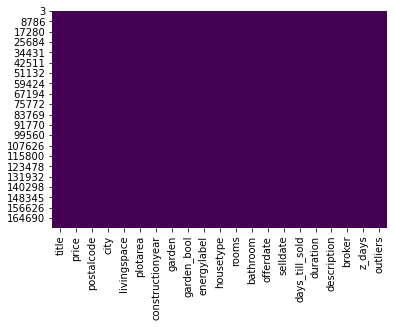

In [21]:
#Storing final dataset
funda_final = funda_no_den
#Exporting clean dataset
funda_final.to_csv('~/Desktop/DDB/ai_business/datasets/clean_dataset.csv', sep = ';')

In [22]:
print("Before cleaning the data, our dataset had", len(csv), "rows.")
print("After cleaning the data, our dataset contains", len(funda_final), "rows.")

Before cleaning the data, our dataset had 173043 rows.
After cleaning the data, our dataset contains 50654 rows.


## Exploratory Data Analysis - Sample

Due to the size of the dataset, a random sample of 1,000 datapoints is explored first. This is to understand if there are variables in particular that should be taken into account when analyzing the full dataset.

In [23]:
#Storing a sample of the final dataset to explore
days_data = funda_final.sample(n = 1000, replace = False, random_state = 1)

#Comparing full dataset to sample data
full_max = math.floor(funda_final['days_till_sold'].max())
full_min = math.floor(funda_final['days_till_sold'].min())
full_mean = math.floor(funda_final['days_till_sold'].mean())
sample_max = math.floor(days_data['days_till_sold'].max())
sample_min = math.floor(days_data['days_till_sold'].min())
sample_mean = math.floor(days_data['days_till_sold'].mean())

print("The full datasaet contained a total amount of", len(funda_final), "houses with a maximum of", full_max, "days, a minimum of", full_min, "days and a mean of", full_mean, "days on Funda.")
print("The sample contains a total amount of", len(days_data), "houses with a maximum of", sample_max, "days, a minimum of", sample_min, "days and a mean of", sample_mean, "days on Funda.")

The full datasaet contained a total amount of 50654 houses with a maximum of 385 days, a minimum of 1 days and a mean of 33 days on Funda.
The sample contains a total amount of 1000 houses with a maximum of 362 days, a minimum of 1 days and a mean of 34 days on Funda.


### . . . . . What influenches Time To Sell (Days Till Sold) ? 

In [24]:
#Conclusions based on the mean
print("Based on our sample of", len(days_data), "houses taken from the dataset, the following findings can be made: \n")
cities = days_data.groupby(['city']).mean().reset_index()
cities = cities.sort_values('days_till_sold', ascending = True)
#print(cities[['city', 'days_till_sold']].head(3))
print("       - On average, the houses that were sold the fastest were in the city", cities['city'].iloc[0])

gardens = days_data.groupby(['garden_bool']).mean().reset_index()
gardens = gardens.sort_values('days_till_sold', ascending = True)
#print(gardens[['garden_bool', 'days_till_sold']].head(3))
gardens_true = gardens[gardens['garden_bool'] == True]['days_till_sold'].iloc[0]
gardens_false = gardens[gardens['garden_bool'] == False]['days_till_sold'].iloc[0]
gardens_true = gardens_true.astype(int)
gardens_false = gardens_false.astype(int)
if gardens_true < gardens_false:
    print("       - On average, if a house had a garden it was sold", (gardens_false - gardens_true), "days faster")
else:
    print("       - On average, if a house had a garden it was sold", (gardens_true - gardens_false), "days slower")

livingspaces = days_data.groupby(['livingspace']).mean().reset_index()
livingspaces = livingspaces.sort_values('days_till_sold', ascending = True)
#print(livingspaces[['livingspace', 'days_till_sold']].head(3))
print("       - On average, houses were sold fastest when they had a size of", livingspaces['livingspace'].iloc[0], "sqm")

rooms = days_data.groupby(['rooms']).mean().reset_index()
rooms = rooms.sort_values('days_till_sold', ascending = True)
#print(rooms[['rooms', 'days_till_sold']].head(3))
print("       - On average, houses were sold fastest when they had", rooms['rooms'].iloc[0], "rooms")

construction_years = days_data.groupby(['constructionyear']).mean().reset_index()
construction_years = construction_years.sort_values('days_till_sold', ascending = True)
#print(construction_years[['constructionyear', 'days_till_sold']].head(3))
print("       - On average, houses were sold fastest if they were constructed in", construction_years['constructionyear'].iloc[0])

brokers = days_data.groupby(['broker']).mean().reset_index()
brokers = brokers.sort_values('days_till_sold', ascending = True)
#print(brokers[['broker', 'days_till_sold']].head(3))
print("       - On average, houses were sold fastest with", brokers['broker'].iloc[0])


Based on our sample of 1000 houses taken from the dataset, the following findings can be made: 

       - On average, the houses that were sold the fastest were in the city Kamperland
       - On average, if a house had a garden it was sold 16 days faster
       - On average, houses were sold fastest when they had a size of 225 sqm
       - On average, houses were sold fastest when they had 5 rooms
       - On average, houses were sold fastest if they were constructed in 2017
       - On average, houses were sold fastest with Kerkvliet Makelaars


Text(0.5, 0.98, '\n What is the impact of different variables on the days to sell on Funda?')

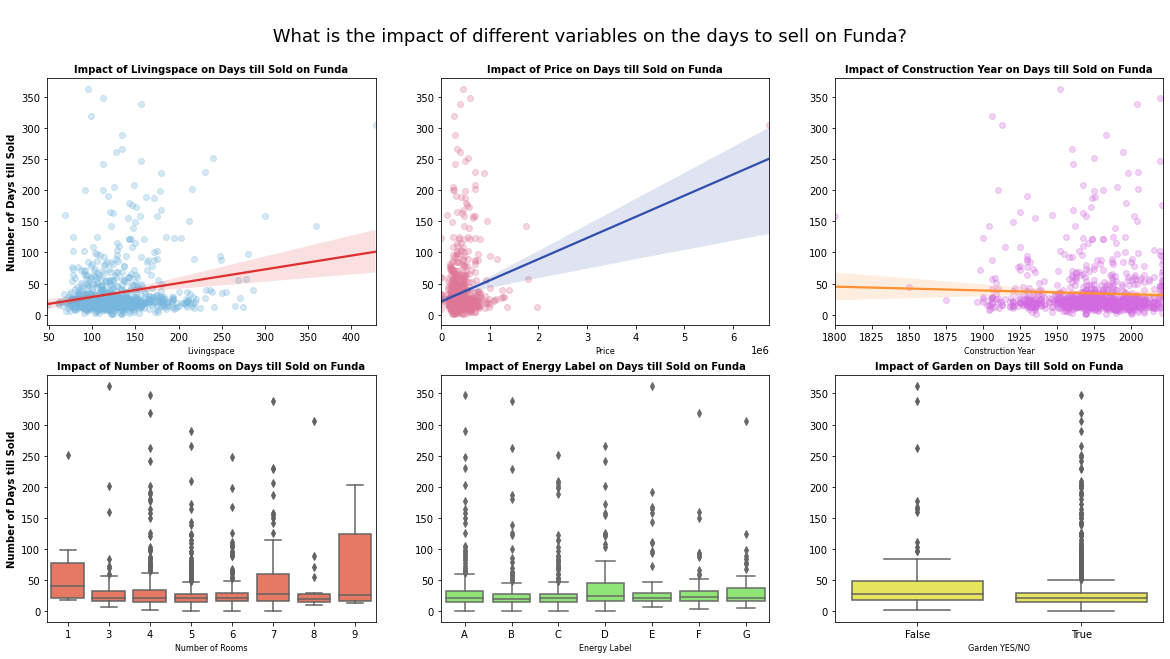

In [25]:
#Impact of different variables on days to sell Visualization
#Specifying Figure Layout
plt.figure(figsize = (20, 10))

plt.subplot(2, 3, 1)
plot1 = sns.regplot(data = days_data, x = 'livingspace', y = 'days_till_sold', color = '#77B7DE', scatter_kws={'alpha':0.3}, line_kws={"color": "#DE3030"})
plot1.set_title("Impact of Livingspace on Days till Sold on Funda", fontdict = {'fontsize' : 10, 'fontweight' : 'heavy'})
plot1.set_xlabel('Livingspace', fontsize = 8)
plot1.set_ylabel('Number of Days till Sold', fontdict = {'fontsize' : 10, 'fontweight' : 'heavy'})

#Creating Plot 2
plt.subplot(2, 3, 2)
plot2 = sns.regplot(data = days_data, x = 'price', y = 'days_till_sold', color = '#DE7796', scatter_kws={'alpha':0.3}, line_kws={"color": "#324EAC"})
plot2.set_title("Impact of Price on Days till Sold on Funda", fontdict = {'fontsize' : 10, 'fontweight' : 'heavy'})
plot2.set_xlabel('Price', fontsize = 8)
plot2.set_ylabel(None)

#Creating Plot 3
plt.subplot(2, 3, 3)
plot3 = sns.regplot(data = days_data, x = 'constructionyear', y = 'days_till_sold', color = '#D26BE0', scatter_kws={'alpha':0.3}, line_kws={"color": "#FF9131"})
plot3.set_title("Impact of Construction Year on Days till Sold on Funda", fontdict = {'fontsize' : 10, 'fontweight' : 'heavy'})
plot3.set_xlabel('Construction Year', fontsize = 8)
plot3.set_ylabel(None)

#Creating Plot 4
plt.subplot(2, 3, 4)
plot4 = sns.boxplot(data = days_data, x = 'rooms', y = 'days_till_sold', color = '#FB6B4D')
plot4.set_title("Impact of Number of Rooms on Days till Sold on Funda", fontdict = {'fontsize' : 10, 'fontweight' : 'heavy'})
plot4.set_xlabel('Number of Rooms', fontsize = 8)
plot4.set_ylabel('Number of Days till Sold', fontdict = {'fontsize' : 10, 'fontweight' : 'heavy'})

#Creating Plot 5
plt.subplot(2, 3, 5)
plot5 = sns.boxplot(data = days_data, x = 'energylabel', y = 'days_till_sold', order = ['A', 'B', 'C', 'D', 'E', 'F', 'G'], color = '#86F766')
plot5.set_title("Impact of Energy Label on Days till Sold on Funda", fontdict = {'fontsize' : 10, 'fontweight' : 'heavy'})
plot5.set_xlabel('Energy Label', fontsize = 8)
plot5.set_ylabel(None)

#Creating Plot 6
plt.subplot(2, 3, 6)
plot6 = sns.boxplot(data = days_data, x = 'garden_bool', y = 'days_till_sold', color = '#FEFB46')
plot6.set_title("Impact of Garden on Days till Sold on Funda", fontdict = {'fontsize' : 10, 'fontweight' : 'heavy'})
plot6.set_xlabel('Garden YES/NO', fontsize = 8)
plot6.set_ylabel(None)

plt.suptitle('\n What is the impact of different variables on the days to sell on Funda?', fontsize = 18)

Based on these visualizations, it is clear to see a strong trend. Even though the Regression Line is pointing towards a trend, it does not seem very reliable, as the datapoints seem to be quite clustered together.
Looking at the Boxplots, the medians between the categories are very close together.

Text(0.5, 1.0, '\n Visualizing the Sample')

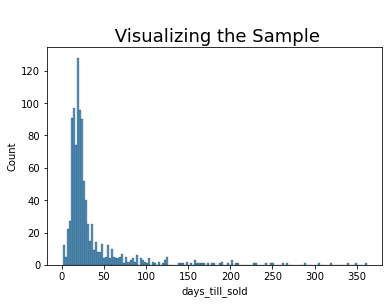

In [26]:
#Visualizing the sample
sns.histplot(data = days_data, x = 'days_till_sold', bins = 150)
plt.title('\n Visualizing the Sample', fontsize = 18)

We can see that the most of our data lies between 1 and 50 days, with a long tail towards the right. It makes sense to divide the data into two extra subsamples (1-50, and 50+ days), in order to see if there is something that stands out.

### . . . . . Comparing houses sold within 50 days and houses sold after 50 days

In order to understand if there are differences between houses that were sold within 50 days and houses that were sold after 50 days, we attach labels to each house based on their days_till_sold variable. 
We have detailed labels, as well as the two main labels (within 50 days/51+ days).

In [27]:
#Adding categories for how long it took to sell a house
#Add selling ranges as category
selling_range = []
for days in days_data['days_till_sold']:
    if (days <= 10) :
        selling_range.append('1-10 days')
    elif (11 <= days <= 20) :
        selling_range.append('11-20 days')
    elif (21 <= days <= 30) :
        selling_range.append('21-30 days')
    elif (31 <= days <= 40) :
        selling_range.append('31-40 days')
    elif (41 <= days <= 50) :
        selling_range.append('41-50 days')
    elif (51 <= days <= 100) :
        selling_range.append('51-100 days')
    elif (101 <= days <= 150) :
        selling_range.append('101-150 days')
    elif (151 <= days <= 200) :
        selling_range.append('151-200 days')
    elif (201 <= days <= 300) :
        selling_range.append('201-300 days')
    elif (days >= 301) : 
        selling_range.append('301+ days')
    else:
        selling_range.append('no selling info')

#Adding column to dataset that includes the selling_range
days_data['selling_range'] = selling_range


#Adding another category sample_ranges in order to divide the sample into two main subsamples
sample_ranges = []

for days in days_data['days_till_sold']:
    if (days <= 50) :
        sample_ranges.append('within 50 days')
    elif (days >= 51) :
        sample_ranges.append('51+ days')

#Adding column to dataset that includes the two subsample-differentiators
days_data['sample_range'] = sample_ranges

#Storing two new subsamples
days50 = days_data[days_data['days_till_sold'] <= 50]
days51plus = days_data[days_data['days_till_sold'] >= 51]

Text(0.5, 0.98, '\n Total Sample: Difference between houses that were sold within 50 days, and after 51 days')

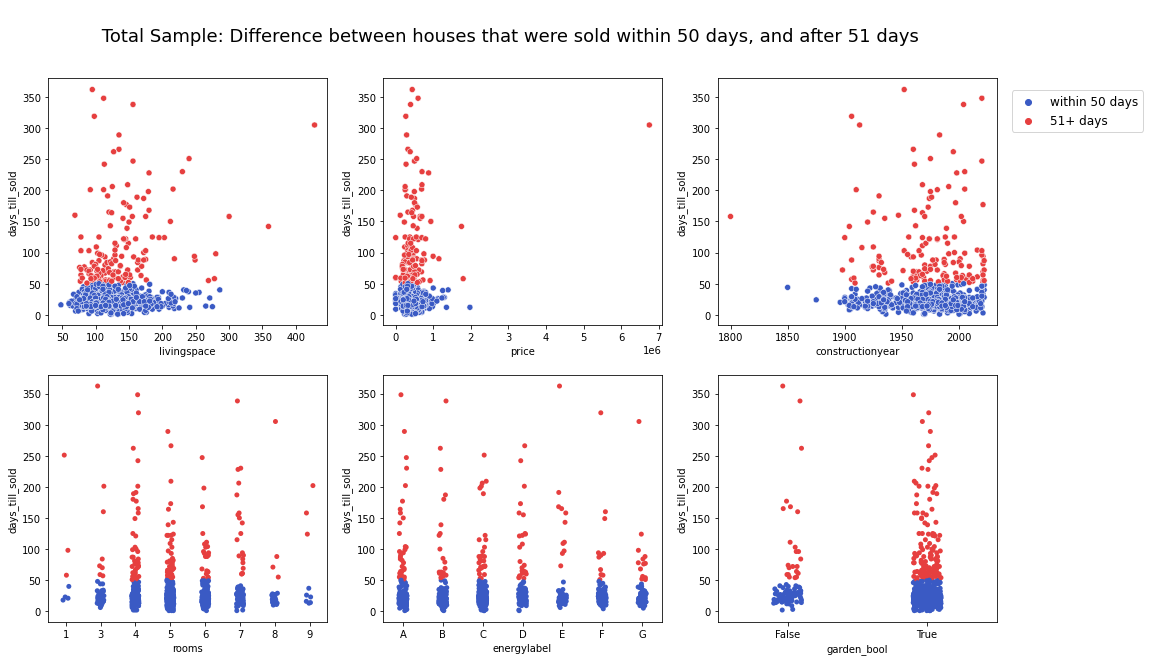

In [28]:
#Visualizing difference between houses sold within 50 days, and houses that took more than 51 days
plt.figure(figsize = (17, 10))

#Plot 1
plt.subplot(2, 3, 1)
plot1 = sns.scatterplot(data = days_data, x = 'livingspace', y = 'days_till_sold', hue = 'sample_range', palette = ['#3A5AC4', '#E63F3F'], legend = False)

#Plot 2
plt.subplot(2, 3, 2)
plot2 = sns.scatterplot(data = days_data, x = 'price', y = 'days_till_sold', hue = 'sample_range', palette = ['#3A5AC4', '#E63F3F'], legend = False)

#Plot 3
plt.subplot(2, 3, 3)
plot3 = sns.scatterplot(data = days_data, x = 'constructionyear', y = 'days_till_sold', hue = 'sample_range', palette = ['#3A5AC4', '#E63F3F'])
plot3.legend(bbox_to_anchor = (1.01, 1), loc = 'upper left', borderaxespad = 1, fontsize = 12)

#Plot 4
plt.subplot(2, 3, 4)
plot4 = sns.stripplot(data = days_data, x = 'rooms', y = 'days_till_sold', hue = 'sample_range', palette = ['#3A5AC4', '#E63F3F'])
plot4.legend([], [], frameon = False)

#Plot 5
plt.subplot(2, 3, 5)
plot5 = sns.stripplot(data = days_data, x = 'energylabel', y = 'days_till_sold', order = ['A', 'B', 'C', 'D', 'E', 'F', 'G'], hue = 'sample_range', palette = ['#3A5AC4', '#E63F3F'])
plot5.legend([], [], frameon = False)

#Plot 6
plt.subplot(2, 3, 6)
plot6 = sns.stripplot(data = days_data, x = 'garden_bool', y = 'days_till_sold', hue = 'sample_range', palette = ['#3A5AC4', '#E63F3F'])
plot6.legend([], [], frameon = False)

plt.suptitle('\n Total Sample: Difference between houses that were sold within 50 days, and after 51 days', fontsize = 18)

Yet again, no clear trend is visible between the two main groups. We can see that there are fewer houses that were sold after 50 days, but outliers exist in both groups. There is no clear indication that one particular variable resulted in a house being sold within 50 days or later.
We now want to analyze the specific selling-ranges as indicated before, using price on the Y axis, since the assumption is "The more expensive a house is, the longer it takes to sell".
Price also had the strongest regression line in the previous visualization.

Text(0.5, 0.98, '\n Impact of Variables and Price on the time to sell ranges between houses sold within 50 days')

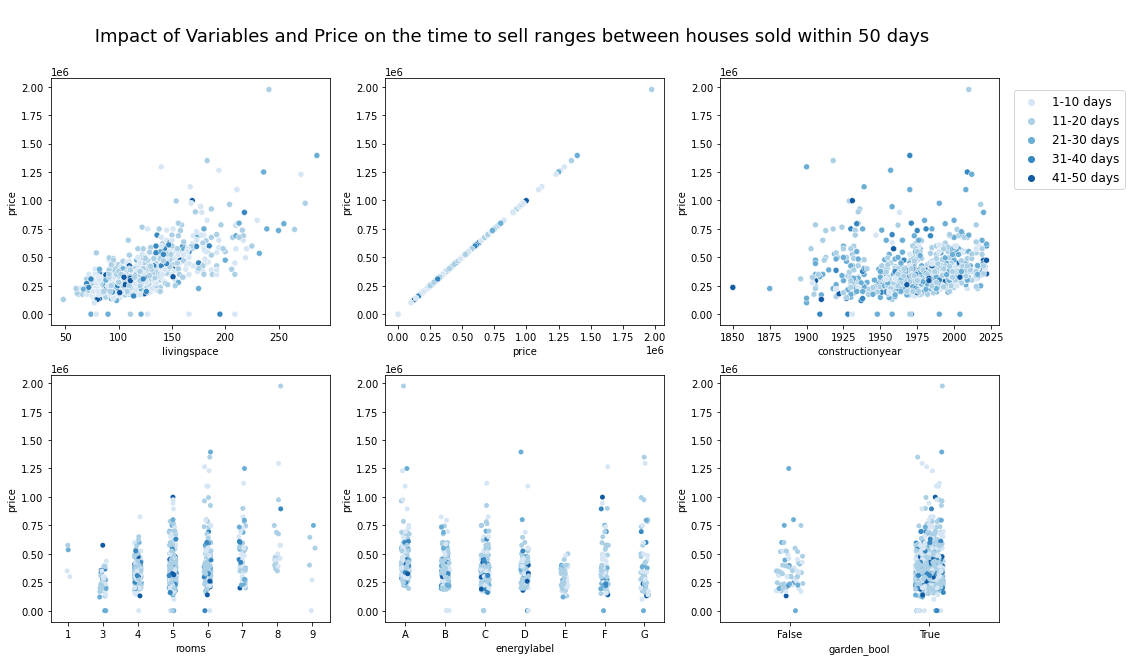

In [75]:
#Visualizing difference between houses sold within 50 days
plt.figure(figsize = (17, 10))

#Plot 1
plt.subplot(2, 3, 1)
plot1 = sns.scatterplot(data = days50, x = 'livingspace', y = 'price', hue = 'selling_range', palette = 'Blues', legend = False)

#Plot 2
plt.subplot(2, 3, 2)
plot2 = sns.scatterplot(data = days50, x = 'price', y = 'price', hue = 'selling_range', palette = 'Blues', legend = False)

#Plot 3
plt.subplot(2, 3, 3)
plot3 = sns.scatterplot(data = days50, x = 'constructionyear', y = 'price', hue = 'selling_range', palette = 'Blues', hue_order = ['1-10 days', '11-20 days', '21-30 days', '31-40 days', '41-50 days'])
plot3.legend(bbox_to_anchor = (1.01, 1), loc = 'upper left', borderaxespad = 1, fontsize = 12)

#Plot 4
plt.subplot(2, 3, 4)
plot4 = sns.stripplot(data = days50, x = 'rooms', y = 'price', hue = 'selling_range', palette = 'Blues')
plot4.legend([], [], frameon = False)

#Plot 5
plt.subplot(2, 3, 5)
plot5 = sns.stripplot(data = days50, x = 'energylabel', y = 'price', order = ['A', 'B', 'C', 'D', 'E', 'F', 'G'], hue = 'selling_range', palette = 'Blues')
plot5.legend([], [], frameon = False)

#Plot 6
plt.subplot(2, 3, 6)
plot6 = sns.stripplot(data = days50, x = 'garden_bool', y = 'price', hue = 'selling_range', palette = 'Blues')
plot6.legend([], [], frameon = False)

plt.suptitle('\n Impact of Variables and Price on the time to sell ranges between houses sold within 50 days', fontsize = 18)

Text(0.5, 0.98, '\n Impact of Variables and Price on the time to sell ranges between houses sold after 51 days')

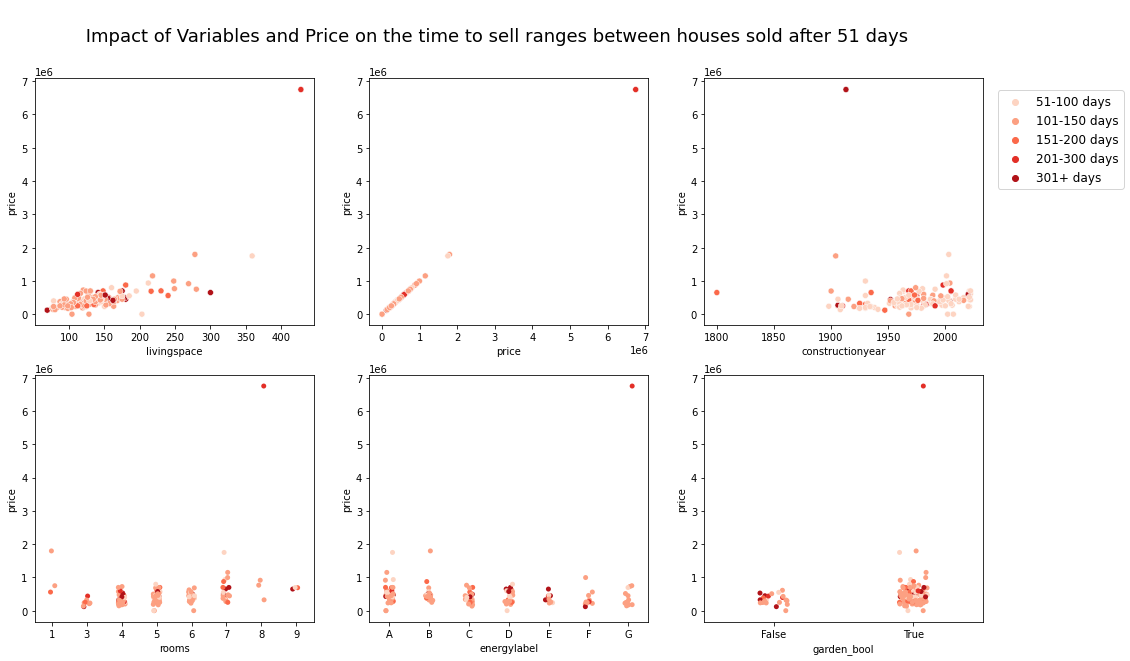

In [76]:
#Visualizing difference between houses sold after 51 days
plt.figure(figsize = (17, 10))

#Plot 1
plt.subplot(2, 3, 1)
plot1 = sns.scatterplot(data = days51plus, x = 'livingspace', y = 'price', hue = 'selling_range', palette = 'Reds', legend = False)

#Plot 2
plt.subplot(2, 3, 2)
plot2 = sns.scatterplot(data = days51plus, x = 'price', y = 'price', hue = 'selling_range', palette = 'Reds', legend = False)

#Plot 3
plt.subplot(2, 3, 3)
plot3 = sns.scatterplot(data = days51plus, x = 'constructionyear', y = 'price', hue = 'selling_range', palette = 'Reds', hue_order = ['51-100 days', '101-150 days', '151-200 days', '201-300 days', '301+ days'])
plot3.legend(bbox_to_anchor = (1.01, 1), loc = 'upper left', borderaxespad = 1, fontsize = 12)

#Plot 4
plt.subplot(2, 3, 4)
plot4 = sns.stripplot(data = days51plus, x = 'rooms', y = 'price', hue = 'selling_range', palette = 'Reds',)
plot4.legend([], [], frameon = False)

#Plot 5
plt.subplot(2, 3, 5)
plot5 = sns.stripplot(data = days51plus, x = 'energylabel', y = 'price', order = ['A', 'B', 'C', 'D', 'E', 'F', 'G'], hue = 'selling_range', palette = 'Reds')
plot5.legend([], [], frameon = False)

#Plot 6
plt.subplot(2, 3, 6)
plot6 = sns.stripplot(data = days51plus, x = 'garden_bool', y = 'price', hue = 'selling_range', palette = 'Reds')
plot6.legend([], [], frameon = False)


plt.suptitle('\n Impact of Variables and Price on the time to sell ranges between houses sold after 51 days', fontsize = 18)

### . . . . . Correlations of houses sold within 50 days and after 50 days

We use the Spearman Rank to plot the Correlation between the two groups.

Text(0.5, 1.0, 'Houses sold after 50 days')

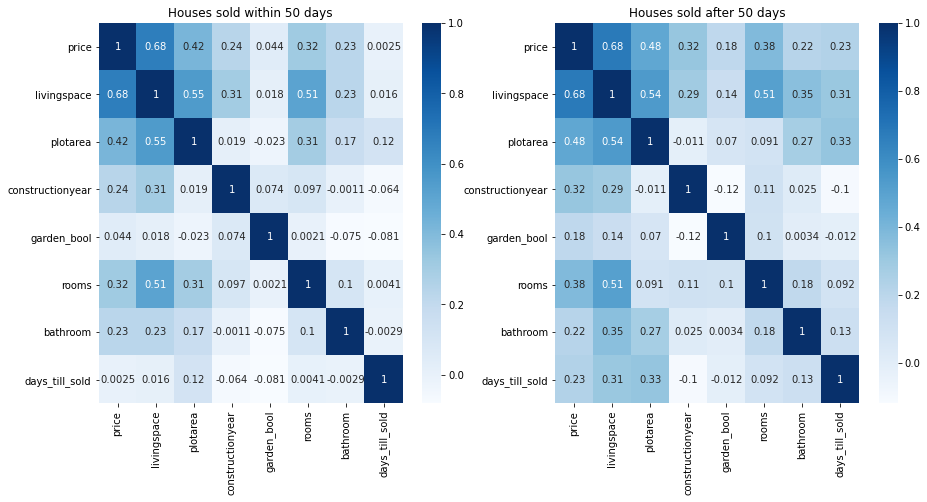

In [77]:
plt.figure(figsize = (15, 7))

plt.subplot(1, 2, 1)
corr_spear = sns.heatmap(days50.iloc[:, 0:17].corr(method = 'spearman'), cbar = True, annot = True, cmap = 'Blues')
corr_spear.set_title("Houses sold within 50 days")

plt.subplot(1, 2, 2)
corr_pear = sns.heatmap(days51plus.iloc[:, 0:17].corr(method = 'spearman'), cbar = True, annot = True, cmap = 'Blues')
corr_pear.set_title("Houses sold after 50 days")

For "days till sold" specifically, there is a higher correlation between the variables in the group of houses that are sold after 50 days. However, that group of houses was also smaller.
Both groups have a negative correlation with the construction year and the garden. Strongest correlation eppears to be the plotarea.
Also livingspace (related to plotarea) and price seem to be the biggest contributors to days till sold, at least in the houses that were sold later.

### . . . . . Is there a difference if the houses are of different types?

To understand if the type of house influences selling time, we now plot the variables for the five most common house types in the dataset.

In [32]:
#Group the houses based on house type
group_houses = days_data.groupby(['housetype'])
#Count number of houses per type
counts = group_houses.size().to_frame(name = 'n').reset_index()
#Retrieve min, median and max for each variable per housetype
housetypes = counts.join(group_houses.agg(['min', 'median', 'max']))
#Retrieve the five most common housetypes
top5_total_sample = housetypes.nlargest(5, 'n')

/Users/vanyamantek/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:9130: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  return merge(


In [33]:
#Storing the five most common housestypes
top5_1 = top5_total_sample['housetype'].iloc[0]
top5_2 = top5_total_sample['housetype'].iloc[1]
top5_3 = top5_total_sample['housetype'].iloc[2]
top5_4 = top5_total_sample['housetype'].iloc[3]
top5_5 = top5_total_sample['housetype'].iloc[4]

top_housetypes = [top5_1, top5_2, top5_3, top5_4, top5_5]

#Filter for only top housetypes in sample
top5_all = days_data[days_data['housetype'].isin(top_housetypes)]

print("The 5 most common house types of our sample are:")
print("       ", top5_1)
print("       ", top5_2)
print("       ", top5_3)
print("       ", top5_4)
print("       ", top5_5)

The 5 most common house types of our sample are:
        Eengezinswoning
        Herenhuis
        Villa
        Bungalow
        Woonboerderij


<AxesSubplot:xlabel='housetype', ylabel='days_till_sold'>

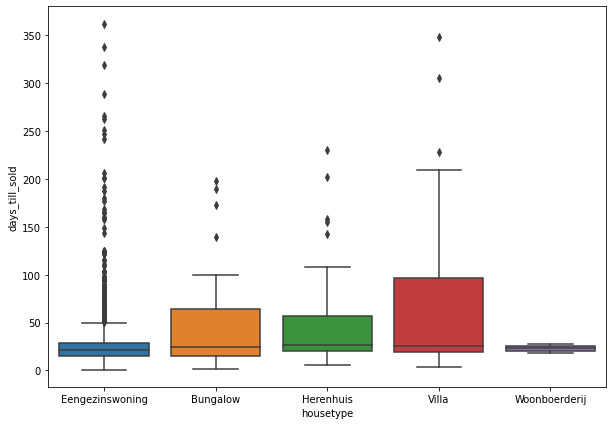

In [34]:
#Boxplot Top 5 House Types - Days Till Sold
plt.figure(figsize = (10, 7))
sns.boxplot(data = top5_all, x = 'housetype', y = 'days_till_sold')

The mean number of days till sold between the top five houses does not seem to differ much. But the spread of the data for each house is different.

Text(0.5, 0.98, 'Top 5 House Types - Impact of different variables on the Days till Sold')

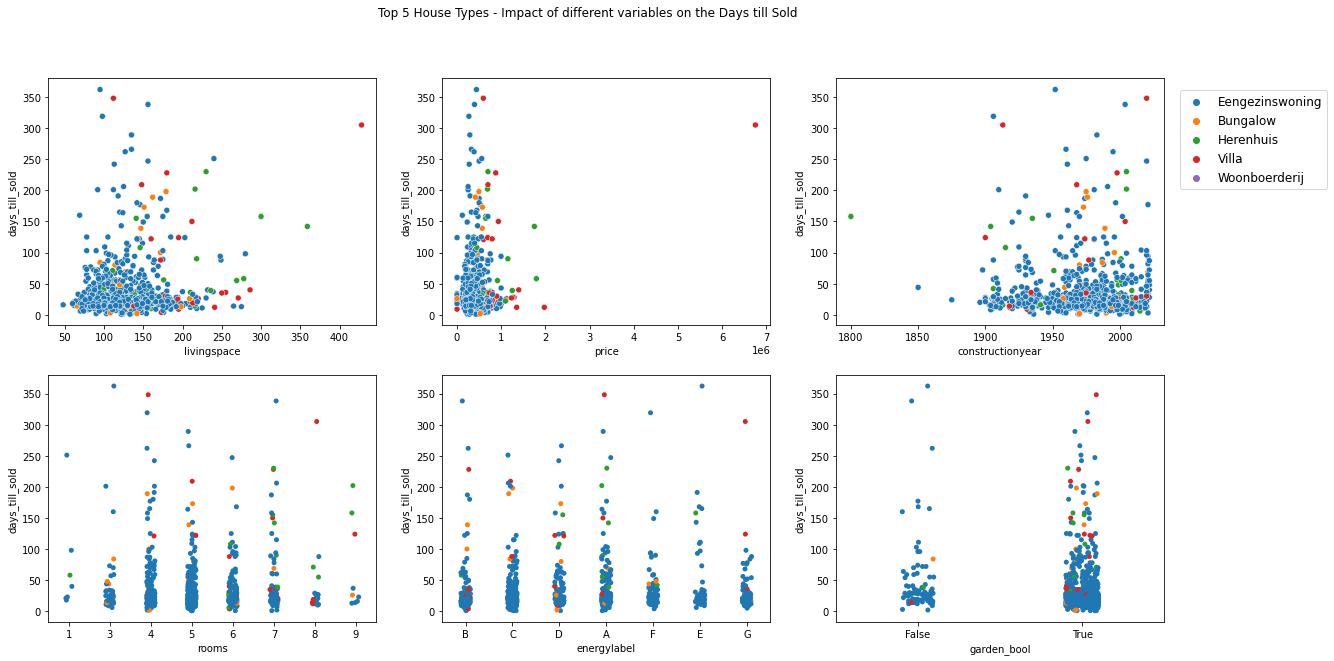

In [35]:
#Plotting Top 5 House Types - Variables
plt.figure(figsize = (20, 10))

#Creating Plot 1
plt.subplot(2, 3, 1)
plot1 = sns.scatterplot(data = top5_all, x = 'livingspace', y = 'days_till_sold', hue = 'housetype')
plot1.legend([], [], frameon = False)

#Creating Plot 2
plt.subplot(2, 3, 2)
plot2 = sns.scatterplot(data = top5_all, x = 'price', y = 'days_till_sold', hue = 'housetype')
plot2.legend([], [], frameon = False)

#Creating Plot 3
plt.subplot(2, 3, 3)
plot3 = sns.scatterplot(data = top5_all, x = 'constructionyear', y = 'days_till_sold', hue = 'housetype')
plot3.legend(bbox_to_anchor = (1.01, 1), loc = 'upper left', borderaxespad = 1, fontsize = 12)

#Creating Plot 4
plt.subplot(2, 3, 4)
plot4 = sns.stripplot(data = top5_all, x = 'rooms', y = 'days_till_sold', hue = 'housetype')
plot4.legend([], [], frameon = False)

#Creating Plot 5
plt.subplot(2, 3, 5)
plot5 = sns.stripplot(data = top5_all, x = 'energylabel', y = 'days_till_sold', hue = 'housetype')
plot5.legend([], [], frameon = False)

#Creating Plot 6
plt.subplot(2, 3, 6)
plot6 = sns.stripplot(data = top5_all, x = 'garden_bool', y = 'days_till_sold', hue = 'housetype')
plot6.legend([], [], frameon = False)

plt.suptitle('Top 5 House Types - Impact of different variables on the Days till Sold')

## Exploratory Data Analysis - Entire (clean) Dataset

We noticed in the sample that plotarea seemed to have the strongest correlation with days_till_sold. We now apply the Correlation Plot for the entire dataset, using both the Spearman's Rank and Pearson method.

Text(0.5, 1.0, 'Pearson Correlation')

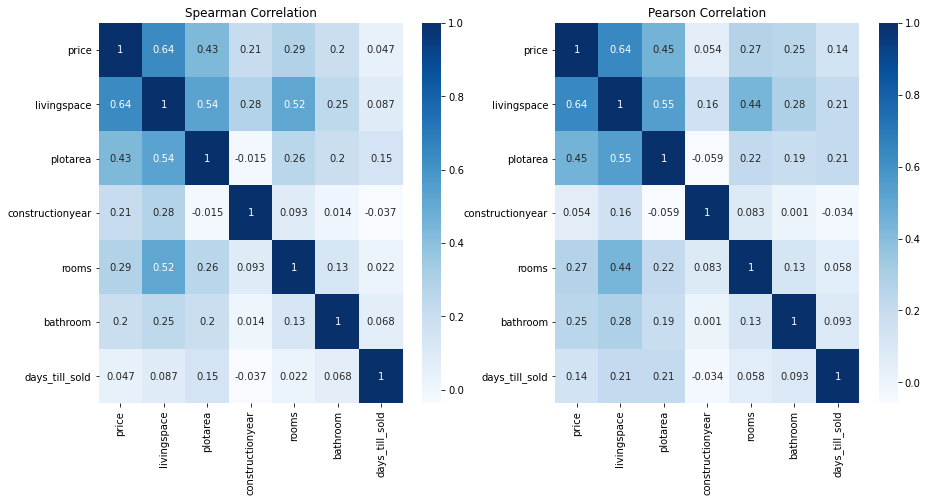

In [36]:
#Correlations (Spearman and Pearson)
plt.figure(figsize = (15, 7))

plt.subplot(1, 2, 1)
correlations = funda_final[['price', 'livingspace', 'plotarea', 'constructionyear', 'rooms', 'bathroom', 'days_till_sold']]
corr_spear = sns.heatmap(correlations.corr(method = 'spearman'), cbar = True, annot = True, cmap = 'Blues')
corr_spear.set_title("Spearman Correlation")

plt.subplot(1, 2, 2)
corr_pear = sns.heatmap(correlations.corr(method = 'pearson'), cbar = True, annot = True, cmap = 'Blues')
corr_pear.set_title("Pearson Correlation")

Both methods reveal livingspace, plotarea and price as perhaps the strongest variables that are correlated to the days till sold, followed by bathrooms and then rooms.
The construction year has a negative correlation to days till sold, but it is still a rather small correlation.

Text(0.5, 0.98, '\n Impact of Numerical Variables on Days Till Sold')

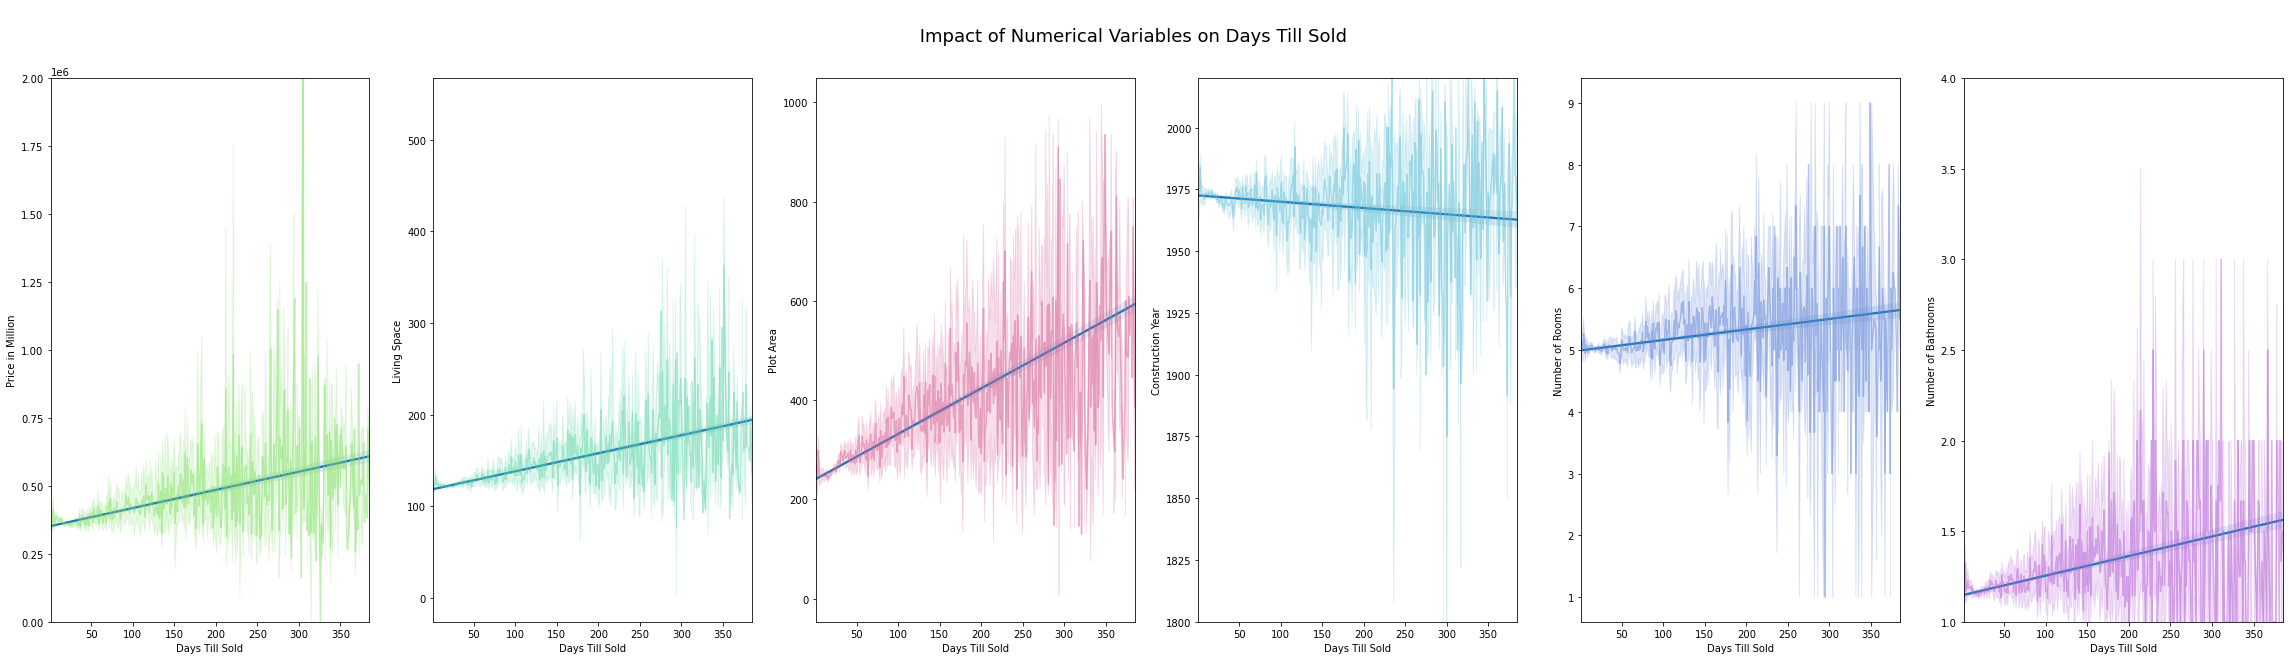

In [37]:
#Line & Regression Plot of all numerical Variables
plt.figure(figsize = (40, 10))

plt.subplot(1, 6, 1)
plt1 = sns.regplot(x = 'days_till_sold', y = 'price', data = funda_final, fit_reg = True, scatter_kws = {'alpha':0.0})
plt1 = sns.lineplot(x = 'days_till_sold', y = 'price', data = funda_final, alpha = 0.5, color = '#84E169')
plt1.set_ylim(0, 2000000)
plt1.set_xlabel("Days Till Sold")
plt1.set_ylabel("Price in Million")

plt.subplot(1, 6, 2)
plt2 = sns.regplot(x = 'days_till_sold', y = 'livingspace', data = funda_final, fit_reg = True, scatter_kws = {'alpha':0.0})
plt2 = sns.lineplot(x = 'days_till_sold', y = 'livingspace', data = funda_final, alpha = 0.5, color = '#62D8AB')
plt2.set_xlabel("Days Till Sold")
plt2.set_ylabel("Living Space")

plt.subplot(1, 6, 3)
plt3 = sns.regplot(x = 'days_till_sold', y = 'plotarea', data = funda_final, fit_reg = True, scatter_kws = {'alpha':0.0})
plt3 = sns.lineplot(x = 'days_till_sold', y = 'plotarea', data = funda_final, alpha = 0.5, color = '#D86298')
plt3.set_xlabel("Days Till Sold")
plt3.set_ylabel("Plot Area")

plt.subplot(1, 6, 4)
plt4 = sns.regplot(x = 'days_till_sold', y = 'constructionyear', data = funda_final, fit_reg = True, scatter_kws = {'alpha':0.0})
plt4 = sns.lineplot(x = 'days_till_sold', y = 'constructionyear', data = funda_final, alpha = 0.5, color = '#62C1D8')
plt4.set_ylim(1800, 2020)
plt4.set_xlabel("Days Till Sold")
plt4.set_ylabel("Construction Year")

plt.subplot(1, 6, 5)
plt5 = sns.regplot(x = 'days_till_sold', y = 'rooms', data = funda_final, fit_reg = True, scatter_kws = {'alpha':0.0})
plt5 = sns.lineplot(x = 'days_till_sold', y = 'rooms', data = funda_final, alpha = 0.5, color = '#6286D8')
plt5.set_xlabel("Days Till Sold")
plt5.set_ylabel("Number of Rooms")

plt.subplot(1, 6, 6)
plt6 = sns.regplot(x = 'days_till_sold', y = 'bathroom', data = funda_final, fit_reg = True, scatter_kws = {'alpha':0.0})
plt6 = sns.lineplot(x = 'days_till_sold', y = 'bathroom', data = funda_final, alpha = 0.5, color = '#B662D8')
plt6.set_ylim(1, 4)
plt6.set_xlabel("Days Till Sold")
plt6.set_ylabel("Number of Bathrooms")

plt.suptitle('\n Impact of Numerical Variables on Days Till Sold', fontsize = 18)

Also the lineplots reveal that plot area is definitely a feature we need to include in our model.
We now seek to understand if any of our categorical variables could be taken into consideration for our model predictions.

Text(0.5, 0.98, '\n Comparing Energy Labels and Housetypes')

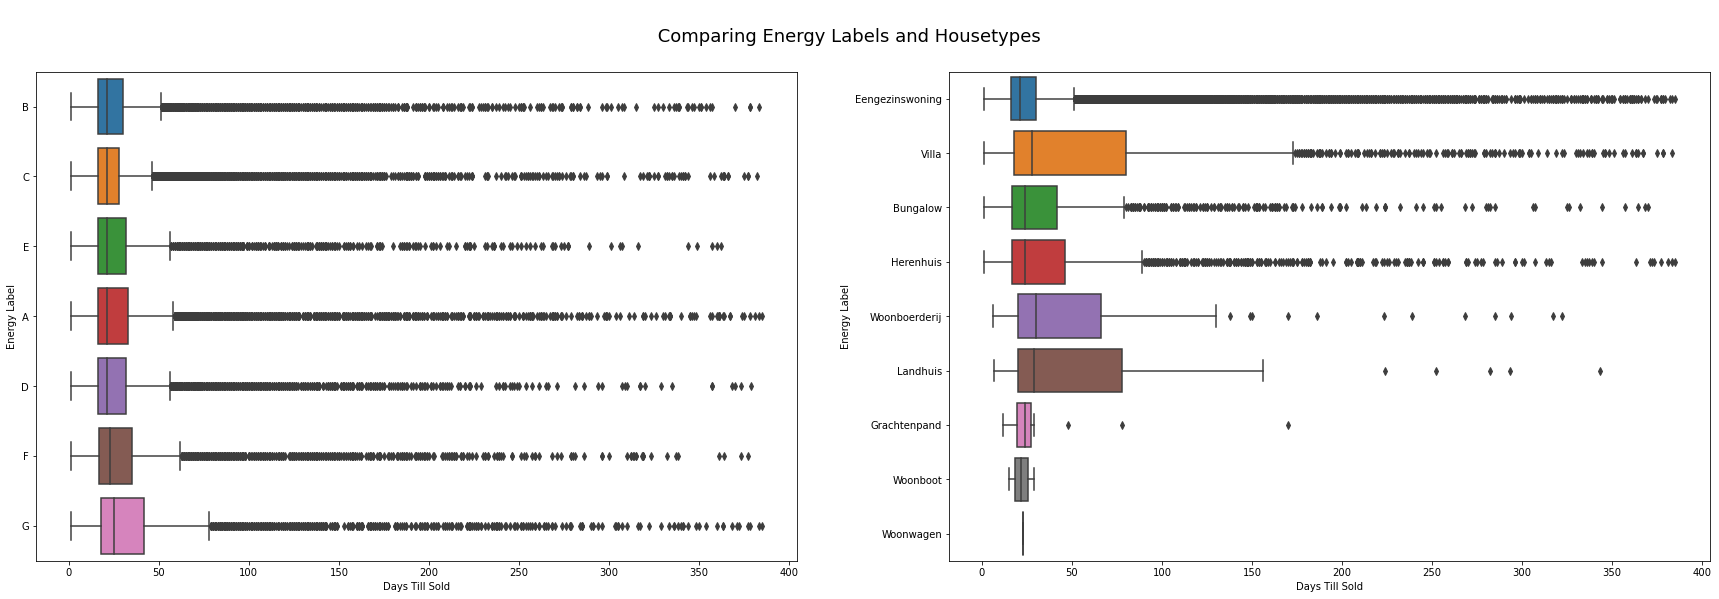

In [38]:
#Comparing Energy Label and Housetypes

plt.figure(figsize = (30, 9))

plt.subplot(1, 2, 1)
plt1 = sns.boxplot(x = 'days_till_sold', y = 'energylabel', data = funda_final)
plt1.set_xlabel("Days Till Sold")
plt1.set_ylabel("Energy Label")

plt.subplot(1, 2, 2)
plt1 = sns.boxplot(x = 'days_till_sold', y = 'housetype', data = funda_final)
plt1.set_xlabel("Days Till Sold")
plt1.set_ylabel("Energy Label")

plt.suptitle("\n Comparing Energy Labels and Housetypes", fontsize = 18)

Text(0.5, 0.98, '\n Comparing Days Till Sold in different Cities')

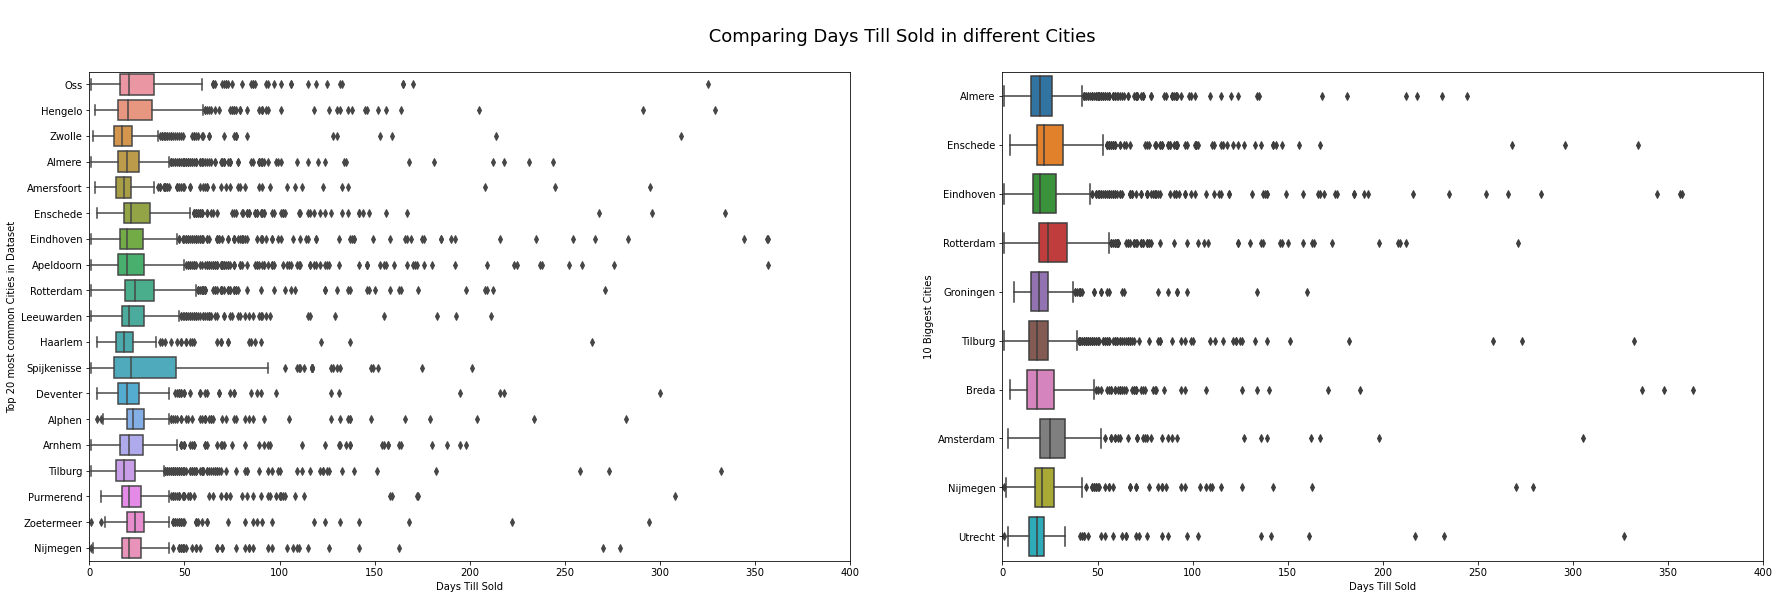

In [39]:
#Comparing influence of different cities

#Subsetting top 20 most common cities in the dataset
top20cities = (funda_final['city'].value_counts().sort_values(ascending = False)[0:19]).reset_index()
top20cities_funda = funda_final.loc[funda_final['city'].isin(top20cities['index'])]

plt.figure(figsize=(30, 9))

plt.subplot(1, 2, 1)
plt1 = sns.boxplot(x = 'days_till_sold', y = 'city', data = top20cities_funda)
plt1.set_xlabel("Days Till Sold")
plt1.set_xlim(0, 400)
plt1.set_ylabel("Top 20 most common Cities in Dataset")

#Subsetting top 10 biggest cities in the Netherlands
big_cities = ['Amsterdam', 'Utrecht', 'Rotterdam', 'Eindhoven', 'Tilburg', 'Groningen', 'Almere', 'Breda', 'Nijmegen', 'Enschede']
big_cities_on_funda = funda_final[funda_final['city'].isin(big_cities)]

plt.subplot(1, 2, 2)
plt2 = sns.boxplot(x = 'days_till_sold', y = 'city', data = big_cities_on_funda)
plt2.set_xlabel("Days Till Sold")
plt2.set_xlim(0, 400)
plt2.set_ylabel("10 Biggest Cities")

plt.suptitle("\n Comparing Days Till Sold in different Cities", fontsize = 18)

Since the mean and overall distribution of the days_till_sold seems pretty similar amongst the cities, as well as energy labels, we doubt they could be helpful for our model. 
We are still uncertain about the house types, which is why we now model each house type and the numerical variables.
If the trend seems to be more or less the same amongst all house types, it does not make sense to include the house types in our model.

In [40]:
#Defining Functions to plot faster

def makePricePlot(data):
    p = sns.regplot(x = 'days_till_sold', y = 'price', data = data, fit_reg = True, scatter_kws = {'alpha':0.0})
    p = sns.lineplot(x = 'days_till_sold', y = 'price', data = data, alpha = 0.5, color = '#84E169')
    p.set_xlim(0, 350)
    p.set_xlabel("Days Till Sold")
    p.set_ylabel("Price in Million")

def makeLivingspacePlot(data):
    p = sns.regplot(x = 'days_till_sold', y = 'livingspace', data = data, fit_reg = True, scatter_kws = {'alpha':0.0})
    p = sns.lineplot(x = 'days_till_sold', y = 'livingspace', data = data, alpha = 0.5, color = '#62D8AB')
    p.set_xlim(0, 350)
    p.set_xlabel("Days Till Sold")
    p.set_ylabel("Living Space")

def makePlotareaPlot(data):
    p = sns.regplot(x = 'days_till_sold', y = 'plotarea', data = data, fit_reg = True, scatter_kws = {'alpha':0.0})
    p = sns.lineplot(x = 'days_till_sold', y = 'plotarea', data = data, alpha = 0.5, color = '#D86298')
    p.set_xlim(0, 350)
    p.set_xlabel("Days Till Sold")
    p.set_ylabel("Plot Area")

def makeConstructionyearPlot(data):
    p = sns.regplot(x = 'days_till_sold', y = 'constructionyear', data = data, fit_reg = True, scatter_kws = {'alpha':0.0})
    p = sns.lineplot(x = 'days_till_sold', y = 'constructionyear', data = data, alpha = 0.5, color = '#62C1D8')
    p.set_xlim(0, 350)
    p.set_xlabel("Days Till Sold")
    p.set_ylabel("Construction Year")

def makeRoomPlot(data):
    p = sns.regplot(x = 'days_till_sold', y = 'rooms', data = data, fit_reg = True, scatter_kws = {'alpha':0.0})
    p = sns.lineplot(x = 'days_till_sold', y = 'rooms', data = data, alpha = 0.5, color = '#6286D8')
    p.set_xlim(0, 350)
    p.set_xlabel("Days Till Sold")
    p.set_ylabel("Number of Rooms")

def makeBathroomPlot(data):
    p = sns.regplot(x = 'days_till_sold', y = 'bathroom', data = data, fit_reg = True, scatter_kws = {'alpha':0.0})
    p = sns.lineplot(x = 'days_till_sold', y = 'bathroom', data = data, alpha = 0.5, color = '#B662D8')
    p.set_ylim(1, 4)
    p.set_xlim(0, 350)
    p.set_xlabel("Days Till Sold")
    p.set_ylabel("Number of Bathrooms")

Text(0.5, 0.98, 'Eengezinswoning')

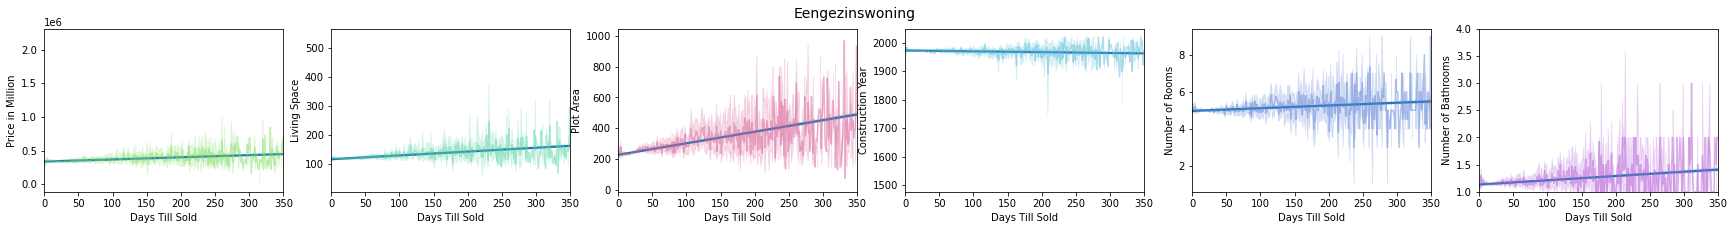

In [41]:
#Plot for Eengezinswoning
h1 = funda_final[funda_final['housetype'] == 'Eengezinswoning']

plt.figure(figsize = (30, 3))

plt.subplot(1, 6, 1)
makePricePlot(data = h1)
plt.subplot(1, 6, 2)
makeLivingspacePlot(data = h1)
plt.subplot(1, 6, 3)
makePlotareaPlot(data = h1)
plt.subplot(1, 6, 4)
makeConstructionyearPlot(data = h1)
plt.subplot(1, 6, 5)
makeRoomPlot(data = h1)
plt.subplot(1, 6, 6)
makeBathroomPlot(data = h1)


plt.suptitle('Eengezinswoning', fontsize = 14)

Text(0.5, 0.98, 'Villa')

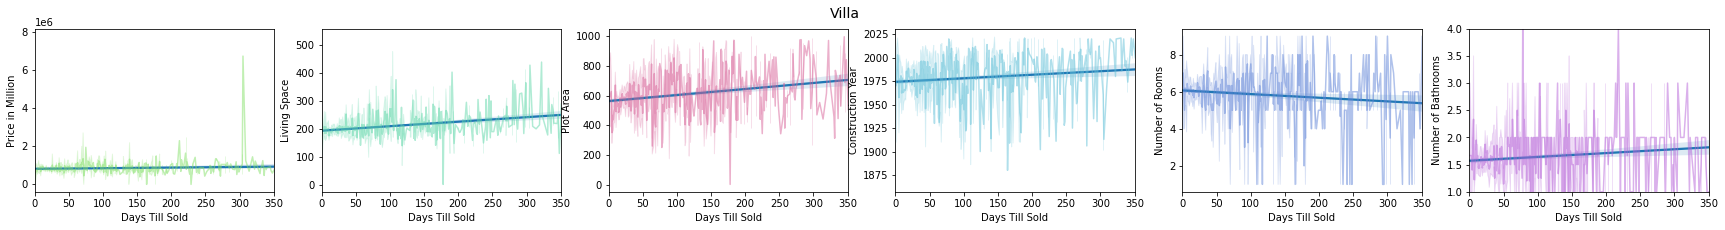

In [42]:
#Plot for Villa
h2 = funda_final[funda_final['housetype'] == 'Villa']

plt.figure(figsize = (30, 3))

plt.subplot(1, 6, 1)
makePricePlot(data = h2)
plt.subplot(1, 6, 2)
makeLivingspacePlot(data = h2)
plt.subplot(1, 6, 3)
makePlotareaPlot(data = h2)
plt.subplot(1, 6, 4)
makeConstructionyearPlot(data = h2)
plt.subplot(1, 6, 5)
makeRoomPlot(data = h2)
plt.subplot(1, 6, 6)
makeBathroomPlot(data = h2)


plt.suptitle('Villa', fontsize = 14)

Text(0.5, 0.98, 'Bungalow')

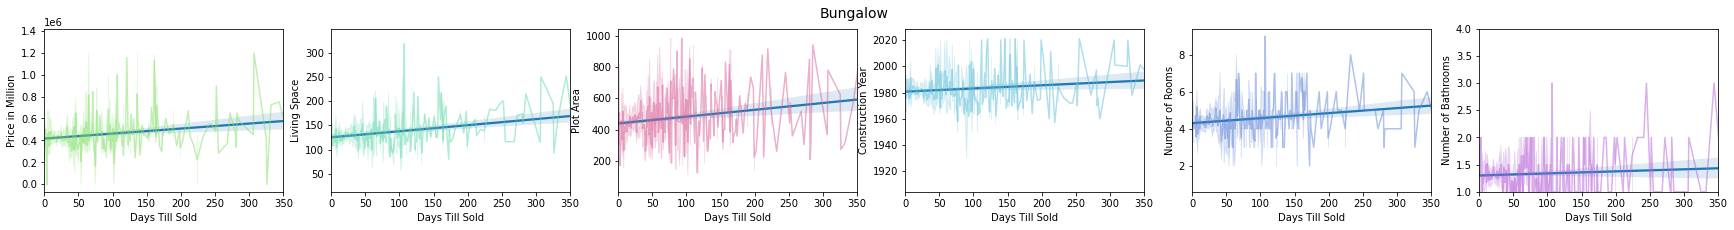

In [43]:
#Plot for Bungalow
h3 = funda_final[funda_final['housetype'] == 'Bungalow']

plt.figure(figsize = (30, 3))

plt.subplot(1, 6, 1)
makePricePlot(data = h3)
plt.subplot(1, 6, 2)
makeLivingspacePlot(data = h3)
plt.subplot(1, 6, 3)
makePlotareaPlot(data = h3)
plt.subplot(1, 6, 4)
makeConstructionyearPlot(data = h3)
plt.subplot(1, 6, 5)
makeRoomPlot(data = h3)
plt.subplot(1, 6, 6)
makeBathroomPlot(data = h3)


plt.suptitle('Bungalow', fontsize = 14)

Text(0.5, 0.98, 'Herenhuis')

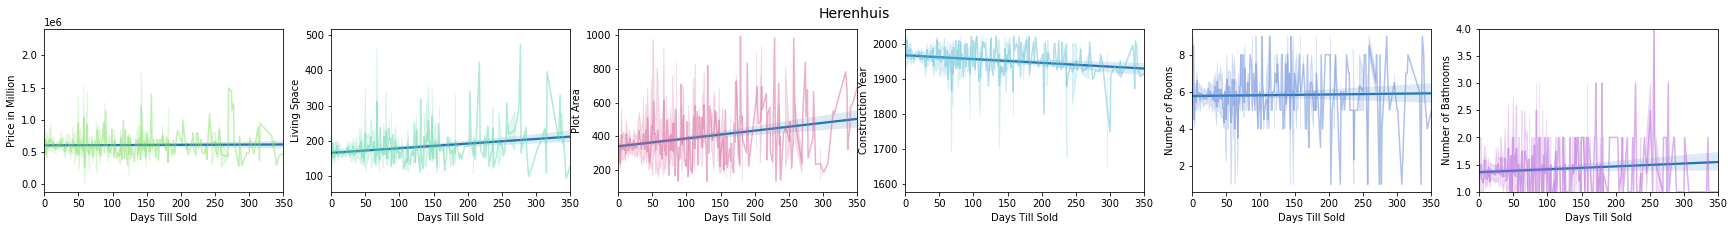

In [44]:
#Plot for Herenhuis
h4 = funda_final[funda_final['housetype'] == 'Herenhuis']

plt.figure(figsize = (30, 3))

plt.subplot(1, 6, 1)
makePricePlot(data = h4)
plt.subplot(1, 6, 2)
makeLivingspacePlot(data = h4)
plt.subplot(1, 6, 3)
makePlotareaPlot(data = h4)
plt.subplot(1, 6, 4)
makeConstructionyearPlot(data = h4)
plt.subplot(1, 6, 5)
makeRoomPlot(data = h4)
plt.subplot(1, 6, 6)
makeBathroomPlot(data = h4)


plt.suptitle('Herenhuis', fontsize = 14)

Text(0.5, 0.98, 'Woonboerderij')

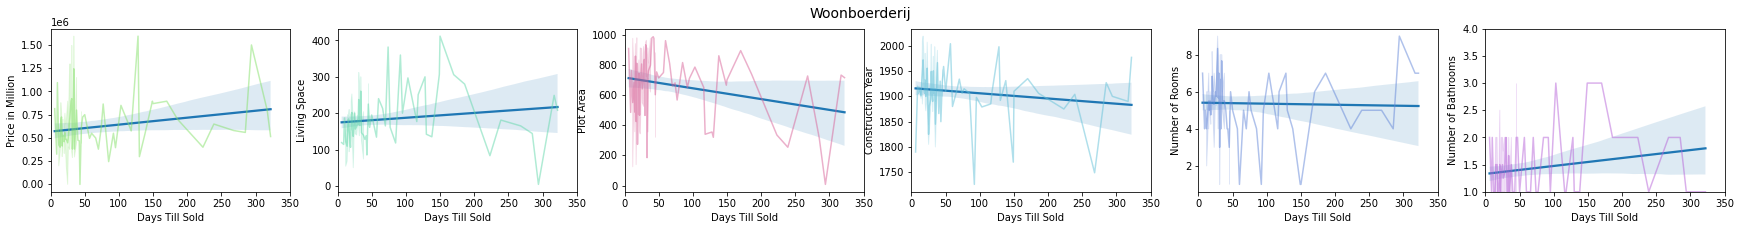

In [45]:
#Plot for Woonboerderij
h5 = funda_final[funda_final['housetype'] == 'Woonboerderij']

plt.figure(figsize = (30, 3))

plt.subplot(1, 6, 1)
makePricePlot(data = h5)
plt.subplot(1, 6, 2)
makeLivingspacePlot(data = h5)
plt.subplot(1, 6, 3)
makePlotareaPlot(data = h5)
plt.subplot(1, 6, 4)
makeConstructionyearPlot(data = h5)
plt.subplot(1, 6, 5)
makeRoomPlot(data = h5)
plt.subplot(1, 6, 6)
makeBathroomPlot(data = h5)


plt.suptitle('Woonboerderij', fontsize = 14)

Text(0.5, 0.98, 'Landhuis')

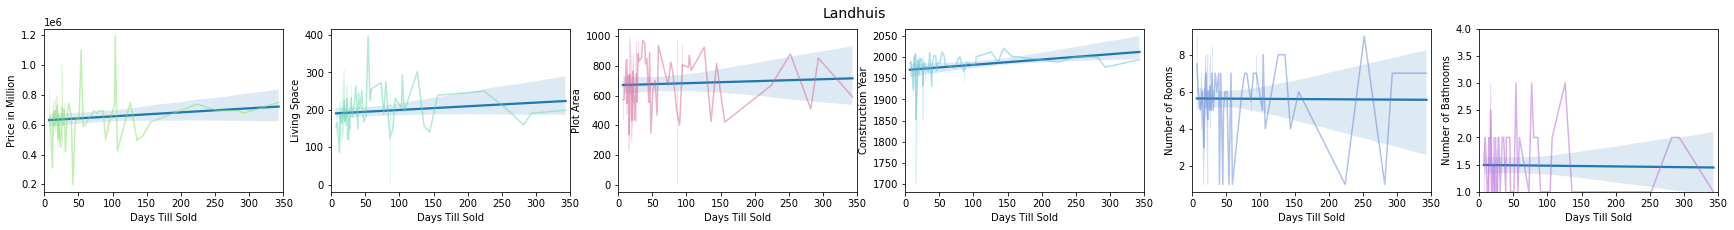

In [46]:
#Plot for Landhuis
h6 = funda_final[funda_final['housetype'] == 'Landhuis']

plt.figure(figsize = (30, 3))

plt.subplot(1, 6, 1)
makePricePlot(data = h6)
plt.subplot(1, 6, 2)
makeLivingspacePlot(data = h6)
plt.subplot(1, 6, 3)
makePlotareaPlot(data = h6)
plt.subplot(1, 6, 4)
makeConstructionyearPlot(data = h6)
plt.subplot(1, 6, 5)
makeRoomPlot(data = h6)
plt.subplot(1, 6, 6)
makeBathroomPlot(data = h6)


plt.suptitle('Landhuis', fontsize = 14)

Text(0.5, 0.98, 'Grachtenpand')

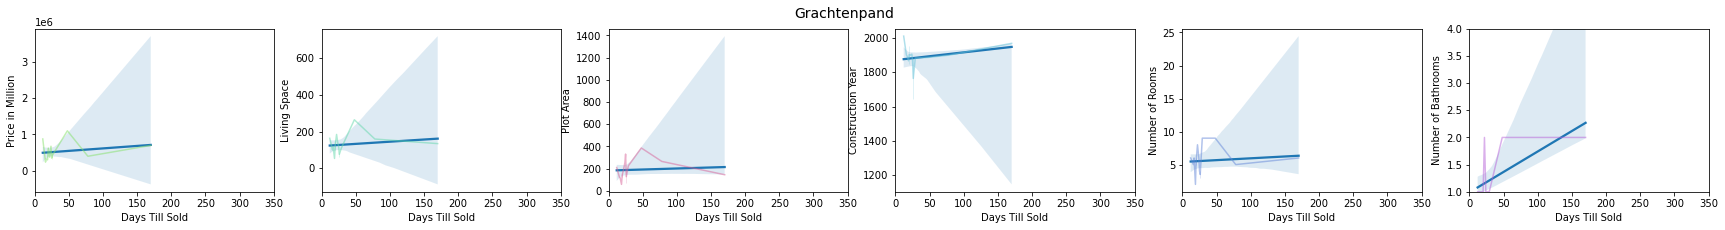

In [47]:
#Plot for Grachtenpand
h7 = funda_final[funda_final['housetype'] == 'Grachtenpand']

plt.figure(figsize = (30, 3))

plt.subplot(1, 6, 1)
makePricePlot(data = h7)
plt.subplot(1, 6, 2)
makeLivingspacePlot(data = h7)
plt.subplot(1, 6, 3)
makePlotareaPlot(data = h7)
plt.subplot(1, 6, 4)
makeConstructionyearPlot(data = h7)
plt.subplot(1, 6, 5)
makeRoomPlot(data = h7)
plt.subplot(1, 6, 6)
makeBathroomPlot(data = h7)


plt.suptitle('Grachtenpand', fontsize = 14)



Text(0.5, 0.98, 'Woonboot')

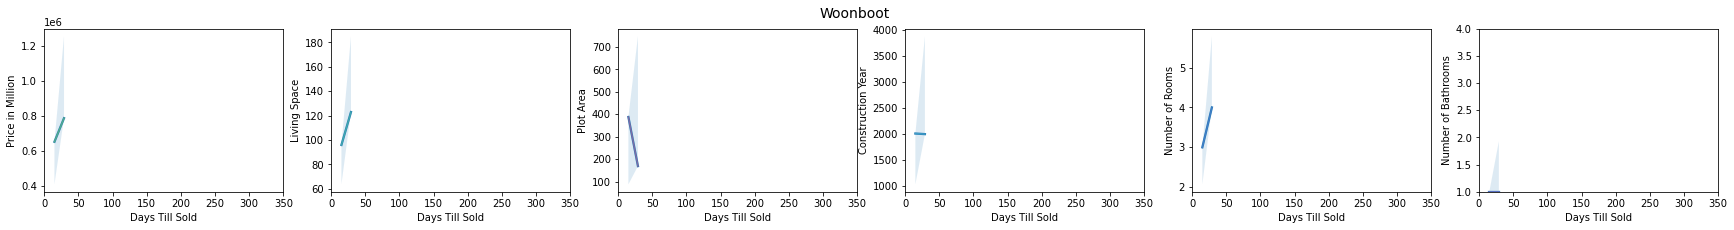

In [48]:
#Plot for Woonboot
h8 = funda_final[funda_final['housetype'] == 'Woonboot']

plt.figure(figsize = (30, 3))

plt.subplot(1, 6, 1)
makePricePlot(data = h8)
plt.subplot(1, 6, 2)
makeLivingspacePlot(data = h8)
plt.subplot(1, 6, 3)
makePlotareaPlot(data = h8)
plt.subplot(1, 6, 4)
makeConstructionyearPlot(data = h8)
plt.subplot(1, 6, 5)
makeRoomPlot(data = h8)
plt.subplot(1, 6, 6)
makeBathroomPlot(data = h8)


plt.suptitle('Woonboot', fontsize = 14)

In [49]:
#Plot for Woonwagen - commented to skip cause only one entry exists
#h9 = funda_final[funda_final['housetype'] == 'Woonwagen']

#plt.figure(figsize = (30, 3))

#plt.subplot(1, 6, 1)
#makePricePlot(data = h9)
#plt.subplot(1, 6, 2)
#makeLivingspacePlot(data = h9)
#plt.subplot(1, 6, 3)
#makePlotareaPlot(data = h9)
#plt.subplot(1, 6, 4)
#makeConstructionyearPlot(data = h9)
#plt.subplot(1, 6, 5)
#makeRoomPlot(data = h9)
#plt.subplot(1, 6, 6)
#makeBathroomPlot(data = h9)


#plt.suptitle('Woonwagen', fontsize = 14)

Reviewing the visualizations of each house type, the only thing that stands out is that the trend line for Woonboerderij goes down when plotting plotarea against days till sold.
However, upon reviewing the dataset, houses of the type Woonboerderij do not even have 100 entries.

## Topic Modelling

Finally, we seek to include the descriptions of the houses in our model as well. For this, we extract topics through Topic Modelling and Text Processing. We clean the description column and extract topics in the following section.

In [50]:
#Load the Dutch language model for Spacy
nlp = spacy.load('nl_core_news_md')

#Storing stopwords for cleaning description column
stopwords = list(STOP_WORDS)

In [91]:
#Cleaning Description Column

#Storing seperate dataset
m = funda_final

#Make everything lower case 
m['description'] = m['description'].str.lower()
#Remove Punctuation
m['description'] = m['description'].str.replace(r'[^\w\s]+', '')
#Storing cleaned Description and removing Numbers
m['clean_description'] = m['description'].str.replace('\d+', '')

<ipython-input-91-d6b611dfaee0>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  m['description'] = m['description'].str.replace(r'[^\w\s]+', '')
<ipython-input-91-d6b611dfaee0>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  m['clean_description'] = m['description'].str.replace('\d+', '')


In [52]:
#Lemmatizing the cleaned Descriptions
#lemmatized = []

#for x in m['clean_description']:
#    docx = nlp(x)
#    docr = str(" ".join([i.lemma_ for i in docx]))
#    lemmatized.append(docr)

#Making column for processed descriptions
#m['processed_description'] = lemmatized

In [92]:
#Tokenizing processed descriptions
m['tokens'] = m['clean_description'].apply(lambda x: [item for item in str(x).split() if item not in stopwords])
#Display original, cleaned and Tokens
m[['description', 'clean_description', 'tokens']].head(3)

,description,clean_description,tokens
3,wat een leuke goed onderhouden tweeondereenkap...,wat een leuke goed onderhouden tweeondereenkap...,"[leuke, goed, onderhouden, tweeondereenkapwoni..."
4,starters opgelet wij hebben een leuke woning t...,starters opgelet wij hebben een leuke woning t...,"[starters, opgelet, leuke, woning, koop, vier,..."
5,in de nabije omgeving van duinen strand geleg...,in de nabije omgeving van duinen strand geleg...,"[nabije, omgeving, duinen, strand, gelegen, go..."


In [93]:
#Defining dummy Function
def dummy(doc):
    return doc

count_vectorizer = CountVectorizer(
    tokenizer=dummy,
    preprocessor=dummy,
    max_df = 0.7,
    min_df = 5,
    max_features=5000 # add the max_features argument
    )

#Establishing Frequency Matrix to count tokens
frequency_matrix = count_vectorizer.fit_transform(m['tokens'])

#Setting up Transformer
tfd_idf_trans = TfidfTransformer()

#Using Transformer to scale down the impact of frequently occuring tokens; gives each token a score
tf_idf_matrix = tfd_idf_trans.fit_transform(frequency_matrix)

#Getting Model with 10 Components
model = NMF(n_components=10, init='nndsvd')

#Fitting the Model
model.fit(X=tf_idf_matrix)

NMF(init='nndsvd', n_components=10)

In [94]:
#Creating Function get_topics
def get_topics(model, n_top_words):
    '''This function takes a fitted NMF factorization model, and a n_top_words parameter.
    It then produces a dataframe where the columns are the topics that have been learned, and the
    rows are the top words that define the topic, ranked by their coefficients.
    '''

    feature_names = count_vectorizer.get_feature_names()
    d = {}
    for i in range(model.n_components):
        # model.components_ matrix contains the matrix H where topics are 
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feature_names[key] for key in words_ids]
        d['Topic # ' + '{:02d}'.format(i+1)] = words
    return pd.DataFrame(d)

In [95]:
#Display Topics
get_topics(model, 20)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,ruimte,â,m,the,mâ²,meetinstructie,e,wanden,garage,x
1,huis,kk,ca,and,ca,koopovereenkomst,vv,plafond,bijkeuken,koper
2,ligt,per,circa,with,mâ³,koper,berging,stucwerk,oprit,ca
3,via,mâ²,inhoud,a,inhoud,particuliere,achtertuin,afgewerkt,toegang,meter
4,grote,vraagprijs,bouwjaar,to,circa,nen,vaste,laminaatvloer,royale,afm
5,twee,a,woonoppervlakte,floor,bouwjaar,verkoper,stenen,toegang,vrijstaande,afmeting
6,heerlijk,bevindt,perceel,house,woonoppervlakte,verschillen,zonnige,vloer,biedt,afmetingen
7,tweede,jaar,woonoppervlak,you,perceel,meten,moderne,tegelvloer,inpandige,onroerende
8,voorzijde,almere,oppervlakte,on,perceeloppervlakte,informatie,achterom,beschikt,via,laminaatvloer
9,fijne,bieden,groot,room,oppervlakte,gebruiksoppervlakte,dakkapel,betegelde,terras,koopovereenkomst


In [146]:
#Store Topics and their score in dataframe
document_topics = model.transform(X=tf_idf_matrix)
document_topics = pd.DataFrame(document_topics)
main_topic = document_topics.idxmax(axis=1)
topics = ["Topic " + str(x) for x in range(1, 11)]
main_topic = main_topic.apply(lambda x: topics[x])

#Attaching Topics to m
m['main_topic'] = main_topic

,tokens,main_topic
3,"[leuke, goed, onderhouden, tweeondereenkapwoni...",Topic 8
4,"[starters, opgelet, leuke, woning, koop, vier,...",Topic 9
5,"[nabije, omgeving, duinen, strand, gelegen, go...",Topic 7
11,"[ruim, wonen, ruime, praktisch, delen, tussenw...",Topic 9
12,"[rand, woonwijk, gelegen, vrijstaande, woning,...",Topic 1
...,...,...
173018,"[gemak, woonwijk, wonen, groen, vindt, tweeond...",NaN
173021,"[achterweg, zz, abbenbroek, verrassend, ruime,...",NaN
173023,"[gewilde, stand, zeelst, gelegen, fors, uitgeb...",NaN
173024,"[prachtig, afgewerkte, hoekwoning, gelegen, po...",NaN


In [171]:
#Storing scores seperately
scores = document_topics

#Joining the scores to the dataset
m_scores = pd.concat([m.reset_index(drop = True), scores.reset_index(drop = True)], axis=1)

#Renaming the scores into their topics
m_new = m_scores.rename(columns= { 0 : 'TopA', 1 : 'TopB', 2: 'TopC', 3 : 'TopD', 4 : 'TopE', 5 : 'TopF', 6 : 'TopG', 7: 'TopH', 8 : 'TopI', 9 : 'TopJ'})


Index([              'title',               'price',          'postalcode',
                      'city',         'livingspace',            'plotarea',
          'constructionyear',              'garden',         'garden_bool',
               'energylabel',           'housetype',               'rooms',
                  'bathroom',           'offerdate',            'selldate',
            'days_till_sold',            'duration',         'description',
                    'broker',              'z_days',            'outliers',
         'clean_description',              'tokens',          'main_topic',
       'sold_within_50_days',                     0,                     1,
                           2,                     3,                     4,
                           5,                     6,                     7,
                           8,                     9],
      dtype='object')

## Repurposing the Dataset for the Model

### . . . . . Updating initial data

In [67]:
#Adding label of selling range to final dataset
days_data['sample_range'] = days_data['sample_range'].astype('string')
days_data['selling'] = days_data['sample_range'].astype('string')

#Adding a category sold_within_50_days to full dataset
sold_within_50_days = []

for days in funda_final['days_till_sold']:
    if (days <= 50) :
        sold_within_50_days.append(1)
    elif (days >= 51) :
        sold_within_50_days.append(0)

#Adding column to dataset that includes the two subsample-differentiators
funda_final['sold_within_50_days'] = sold_within_50_days
#Changing last datatype
funda_final['bathroom'] = funda_final['bathroom'].astype(int)

<ipython-input-67-dd15492f50c8>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funda_final['sold_within_50_days'] = sold_within_50_days
<ipython-input-67-dd15492f50c8>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funda_final['bathroom'] = funda_final['bathroom'].astype(int)


### . . . . . Feature Selection

After exploring a sample of our dataset of 1,000 houses and realizing that the categorical variables (house type, energy label) do not seem to have a big influence on Days Till Sold, the entire dataset was utilized to understand the impact of variables on the time it takes to sell a house.
The variables that stood out the most, in our sample as well as the entire dataset, was Price: houses who are cheaper seem to be sold faster.
We can see that plotarea influences days till sold even more so than living space. We could also previously see in our sample data that having a garden usually makes a house sell slightly faster, which would go in line with the stronger impact on plotarea (since plotarea also incorporates gardens).
We also see that, while all variables have a positive impact on days till sold, construction year is the only one that has a negative correlation with it. This can also be seen in both correlation plots, using both the Pearson method and the Spearman's Rank. There, we could also see that Plotarea had the most positive correlation with Days Till Sold.

The boxplots showed a very similar data distribution and mean for Energy Label and House Types, as well as bigger cities and the 20 most common cities in our dataset.
Regardless, since the spead of the data seemed to be slightly different between each house type, a final visual analysis for each house type has been performed. It becomes clear that the trend for each variable amongst each house type is fairly similar. The only difference that stood out was that houses of the type Woonboerderij seem to take longer to sell the smaller their plotarea is, different from all other house types, for which an increase in plotarea was related to longer selling time. However, there are not even 100 entries of the type Woonboerderij in our dataset of over 50,000 datapoints. This difference, therefore, does not justify to take the house type as a feature into the model.

It seems as if the categorical variables, therefore, would not really do anything when it comes to predicting time to sell with ML models. Therefore, it makes sense to use the numerical variables for our predictions. We also include the scores of the topics that we received through topic modelling for our final prediction. 

Our features for our model are therefore the following:

- topics (TopA - TopJ)
- price 
- livingspace
- plotarea
- constructionyear
- number of rooms
- number of bathrooms

In [183]:
#Final Feature Selection

features = m_new[['TopA', 'TopB', 'TopC', 'TopD', 'TopE', 'TopF', 'TopG', 'TopH', 'TopI', 'TopJ', 'price', 'livingspace', 'plotarea', 'constructionyear', 'rooms', 'bathroom', 'days_till_sold']]
features_for_classification = m_new[['TopA', 'TopB', 'TopC', 'TopD', 'TopE', 'TopF', 'TopG', 'TopH', 'TopI', 'TopJ', 'price', 'livingspace', 'plotarea', 'constructionyear', 'rooms', 'bathroom', 'sold_within_50_days']]
print(features.head())

features.to_csv('~/Desktop/DDB/ai_business/datasets/features.csv', sep = ';')
features_for_classification.to_csv('~/Desktop/DDB/ai_business/datasets/features_for_classification.csv', sep = ';')


       TopA      TopB      TopC      TopD      TopE      TopF      TopG  \
0  0.022687  0.007394  0.000000  0.001189  0.009245  0.000000  0.005987   
1  0.027982  0.000000  0.022138  0.000000  0.000800  0.011183  0.023545   
2  0.000000  0.000000  0.000418  0.000000  0.001869  0.000000  0.092261   
3  0.022065  0.000028  0.000000  0.000000  0.016810  0.000000  0.013598   
4  0.000965  0.000861  0.000000  0.006831  0.013774  0.000925  0.008954   

       TopH      TopI      TopJ   price  livingspace  plotarea  \
0  0.000471  0.011170  0.000000  325000          105       204   
1  0.000000  0.000388  0.000000  175000           78       132   
2  0.000000  0.003977  0.001577  419000          112       248   
3  0.054096  0.006977  0.000000  289000          119       152   
4  0.016396  0.038652  0.000000  539000          143       580   

   constructionyear  rooms  bathroom  days_till_sold  
0              1985      5         1              16  
1              1986      4         1      

In [207]:
features

,TopA,TopB,TopC,TopD,TopE,TopF,TopG,TopH,TopI,TopJ,price,livingspace,plotarea,constructionyear,rooms,bathroom,days_till_sold
0,0.022687,0.007394,0.000000,0.001189,0.009245,0.000000,0.005987,0.000471,0.011170,0.000000,325000,105,204,1985,5,1,16
1,0.027982,0.000000,0.022138,0.000000,0.000800,0.011183,0.023545,0.000000,0.000388,0.000000,175000,78,132,1986,4,1,15
2,0.000000,0.000000,0.000418,0.000000,0.001869,0.000000,0.092261,0.000000,0.003977,0.001577,419000,112,248,1969,5,1,13
3,0.022065,0.000028,0.000000,0.000000,0.016810,0.000000,0.013598,0.054096,0.006977,0.000000,289000,119,152,1974,5,1,14
4,0.000965,0.000861,0.000000,0.006831,0.013774,0.000925,0.008954,0.016396,0.038652,0.000000,539000,143,580,1979,4,1,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50649,0.013529,0.000000,0.000000,0.000000,0.009660,0.000000,0.028071,0.007568,0.020303,0.000000,459000,108,280,1980,4,1,19
50650,0.002739,0.088473,0.026179,0.000351,0.004336,0.070294,0.025694,0.004241,0.000000,0.000000,299900,140,183,1980,6,1,40
50651,0.000000,0.000000,0.000000,0.000000,0.014653,0.000000,0.022937,0.029748,0.035464,0.000236,450000,131,268,1963,5,1,39
50652,0.008729,0.000039,0.000000,0.000542,0.072851,0.000000,0.032787,0.011191,0.000871,0.000000,575000,139,183,2017,5,1,31


In [187]:
print(" . . . .  the end.")

 . . . .  the end.
